In [2]:
# Importing Various Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.regression.linear_model import WLS
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
import quandl

In [3]:
GC = pd.read_csv('/Users/gavinhartzell/Downloads/gold1.csv',na_filter = True, keep_default_na = False)
SI = pd.read_csv('/Users/gavinhartzell/Downloads/silver1.csv',na_filter = True, keep_default_na = False)
models = {}


In [4]:
GC_F = []
SI_F = []
limiting = min(len(GC['Settle']),len(SI['Settle']))
if(limiting<1000):
    fac = 2
else:
    fac = 4
datelist = []
for val in GC['Settle'][0:int(limiting)]:
    GC_F.insert(0,val)
for val in SI['Settle'][0:int(limiting)]:
    SI_F.insert(0,val)
for val in GC['Date'][0:int(limiting)]:
    datelist.insert(0,val)


In [5]:
def test_unitroot(a,b):
    GC_ADF = adfuller(a)
    SI_ADF = adfuller(b)
    if(GC_ADF[1]>0.01 and SI_ADF[1]>0.01):
        print('Unit Roots Validated')
    else:
        if(GC_ADF[1]>0.10):
            print('failure, gold')
        else:
            print('failure,silver')
test_unitroot(GC_F,SI_F)
test_unitroot(np.log(GC_F),np.log(SI_F))


Unit Roots Validated
Unit Roots Validated


In [6]:
x = sm.add_constant(SI_F)
logx = sm.add_constant(SI_F)
logx=np.log(logx)
y = GC_F
logy = np.log(y)
model = sm.OLS(y,x)
results = model.fit()
models['OLS1'] = [datelist,results.params,SI_F,GC_F,[],[],[],SI_F,GC_F]
model = sm.OLS(logy,x)
results = model.fit()
models['OLS2'] = [datelist,results.params,SI_F,GC_F,[],[],[],SI_F,np.log(GC_F)]
model = sm.OLS(y,logx)
results = model.fit()
models['OLS3'] = [datelist,results.params,SI_F,GC_F,[],[],[],np.log(SI_F),GC_F]
model = sm.OLS(logy,logx)
results = model.fit()
models['OLS4'] = [datelist,results.params,SI_F,GC_F,[],[],[],np.log(SI_F),np.log(GC_F)]


In [7]:
def create_OLS(x,y):
    resultlist = []
    logx = np.log(x)
    logy = np.log(y)
    model = sm.OLS(y,x)
    results = model.fit()
    resultlist.append(results)
    model = sm.OLS(x,logy)
    results = model.fit()
    resultlist.append(results)
    model = sm.OLS(logx,logy)
    results = model.fit()
    resultlist.append(results)
    model = sm.OLS(logx,y)
    results = model.fit()
    resultlist.append(results)
    return resultlist

In [8]:
model = sm.WLS(y,x)
results = model.fit()
models['WLS1'] = [datelist,results.params,SI_F,GC_F,[],[],[],SI_F,GC_F]
model = sm.OLS(logy,x)
results = model.fit()
models['WLS2'] = [datelist,results.params,SI_F,GC_F,[],[],[],SI_F,np.log(GC_F)]
model = sm.OLS(y,logx)
results = model.fit()
models['WLS3'] = [datelist,results.params,SI_F,GC_F,[],[],[],np.log(SI_F),GC_F]
model = sm.OLS(logy,logx)
results = model.fit()
models['WLS4'] = [datelist,results.params,SI_F,GC_F,[],[],[],np.log(SI_F),np.log(GC_F)]
for key in models:
    yhat = []
    epsilon = []
    for val in range(0,len(SI_F)):
        yhat.append(models[key][7][val]*models[key][1][1]+ models[key][1][0])
        epsilon.append(models[key][8][val] -(models[key][7][val]*models[key][1][1]+ models[key][1][0]))
        models[key][4] = (yhat)
        models[key][5] = (epsilon)
print(np.mean(models['OLS2'][5]))

-5.907681047637842e-16


In [9]:
print(len(models[key][5]))
print(len(models[key][2]))
print(len(models[key][3]))
print(len(models[key][7]))
print(len(models[key][8]))

3945
3945
3945
3945
3945


In [10]:
for key in models:
    models[key][6] = []
    models_pacf = pacf(models[key][5], method = 'ywunbiased', nlags = 60)
    for val in range(0,len(models_pacf)):
        if models_pacf[val]>0.1 or models_pacf[val]<-0.1:
            models[key][6].append(val)
    models[key][6].append(365)


In [11]:
for key in models:
    for lag in models[key][6]:
        print(key + " : " + str(lag))
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff
diffmodels = {}
for key in models:
    for lag in models[key][6]:
        lags=[]
        exog = []
        endog = []
        if(lag!= 0 and lag != 1):
            epsilon = difference(models[key][5],lag)
            models_pacf = pacf(epsilon, method = 'ywunbiased', nlags = 60)
            for val in range(0,len(models_pacf)):
                if models_pacf[val]>0.1 or models_pacf[val]<-0.1:
                    lags.append(val)
            yhat = []
            for val in range(0,len(epsilon)):
                yhat.append(GC_F[val] - epsilon[val])
                exog.append(SI_F[val+lag])
                endog.append(GC_F[val+lag])
            diffmodels[key + 'diff' + str(lag)] = [models[key][0],models[key][1],exog,endog,yhat,epsilon,lags,models[key][7],models[key][8]]
for key in models:
    for lag in models[key][6]:
        lags=[]
        exog = []
        endog = []
        if(lag!= 0 and lag != 1):
            epsilon = difference(models[key][5],lag)
            models_pacf = pacf(epsilon, method = 'ywunbiased', nlags = 60)
            for val in range(0,len(models_pacf)):
                if models_pacf[val]>0.1 or models_pacf[val]<-0.1:
                    lags.append(val)
            yhat = []
            for val in range(0,len(epsilon)):
                yhat.append(GC_F[val+lag] - epsilon[val])
                exog.append(SI_F[val+lag])
                endog.append(GC_F[val+lag])
            diffmodels[key + 'diff' + str(lag)] = [models[key][0],models[key][1],exog,endog,yhat,epsilon,lags,models[key][7],models[key][8]]
        
for key in diffmodels:
    models[key] = diffmodels[key]


OLS1 : 0
OLS1 : 1
OLS1 : 2
OLS1 : 29
OLS1 : 365
OLS2 : 0
OLS2 : 1
OLS2 : 2
OLS2 : 29
OLS2 : 365
OLS3 : 0
OLS3 : 1
OLS3 : 2
OLS3 : 365
OLS4 : 0
OLS4 : 1
OLS4 : 365
WLS1 : 0
WLS1 : 1
WLS1 : 2
WLS1 : 29
WLS1 : 365
WLS2 : 0
WLS2 : 1
WLS2 : 2
WLS2 : 29
WLS2 : 365
WLS3 : 0
WLS3 : 1
WLS3 : 2
WLS3 : 365
WLS4 : 0
WLS4 : 1
WLS4 : 365


In [12]:
trendmodels = {}
for key in models:
    model = sm.OLS(models[key][5],models[key][2])
    results = model.fit()
    if(results.params[0]<-2 or results.params[0]>2):
        slope = results.params[0]
        epsilon = []
        yhat = []
        for val in range(0,len(models[key][5])):
            epsilon.append(models[key][5][val] - slope * models[key][2][val])
            yhat.append(models[key][3][val] - (models[key][5][val] - slope * models[key][2][val]))
        params = list(models[key][1])
        params.append([slope])
        lags = []
        models_pacf = pacf(epsilon, method = 'ywunbiased', nlags = 60)
        for val in range(0,len(models_pacf)):
                if models_pacf[val]>0.1 or models_pacf[val]<-0.1:
                    lags.append(val)
        trendmodels[key + 'determinstictrend' + str(int(slope))] = [models[key][0],params,models[key][2],models[key][3],yhat,epsilon,lags,models[key][7],models[key][8]]


In [13]:
for key in trendmodels:
    models[key] = trendmodels[key]


In [14]:
for key in models:
    yhat = []
    exog = []
    endog = []
    epsilon = difference(models[key][5],1)
    for val in range(1,len(epsilon)+1):
        yhat.append(GC_F[val] - epsilon[val-1])
        exog.append(SI_F[val])
        endog.append(GC_F[val])
    params = list(models[key][1])
    lags = []
    models_pacf = pacf(epsilon, method = 'ywunbiased', nlags = 60)
    for val in range(0,len(models_pacf)):
            if models_pacf[val]>0.1 or models_pacf[val]<-0.1:
                lags.append(val)
    diffmodels[key + 'difference1'] = [models[key][0],models[key][1],exog,endog,yhat,epsilon,lags,models[key][7],models[key][8]]


In [15]:
for key in diffmodels:
    models[key] = diffmodels[key]


In [16]:
mmodels = {}
count = 0
for key in models:
    count +=1
    print(str(count) + '/' + str(len(models)))
    mod = ar_select_order(models[key][5],maxlag = 60,ic='aic')
    if(len(mod.ar_lags > 0)):
        l2 = []
        model = AutoReg(models[key][5],lags = mod.ar_lags,trend='n')
        results = model.fit()
        maxlag = len(results.params)
        exog = []
        endog = []
        yhat =[]
        epsilon = []
        for i in range(maxlag,len(models[key][5])):
            exog.append(SI_F[i])
            endog.append(GC_F[i])
            sum = 0
            for lag in range(0,maxlag):
                sum += float(results.params[lag]) * models[key][5][len(models[key][5])-i-lag-1]
            epsilon.insert(0,sum)
        paramsfinal = list(models[key][1])
        params = []
        for val in results.params:
            params.append(val)
        paramsfinal.append(params)
        paramsfinal = np.array(paramsfinal)
        for f in range(0,len(epsilon)):
            yhat.append(endog[f] - epsilon[f])
        lags = list(mod.ar_lags)
        mmodels[key + 'AR' + str(maxlag)] = [models[key][0],paramsfinal,exog,endog,yhat,epsilon,lags,models[key][7],models[key][8]]
for key in mmodels:
    if key == 'OLS2AR53':
        print(np.mean(mmodels['OLS2AR53'][5]))
    models[key] = mmodels[key]


1/60
2/60
3/60
4/60
5/60
6/60
7/60
8/60
9/60
10/60
11/60
12/60
13/60
14/60
15/60
16/60
17/60
18/60
19/60
20/60
21/60
22/60
23/60
24/60
25/60
26/60
27/60
28/60
29/60
30/60
31/60
32/60
33/60
34/60
35/60
36/60
37/60
38/60
39/60
40/60
41/60
42/60
43/60
44/60
45/60
46/60
47/60
48/60
49/60
50/60
51/60
52/60
53/60
54/60
55/60
56/60
57/60
58/60
59/60
60/60


In [17]:
ar1models = {}
count = 0
for key in models:
    count+=1
    print(100*count/len(models))
    eps = []
    for val in models[key][5]:
        eps.append(val)
    print(len(models[key][5]))
    if(key != 'OLS1AR14'):
        model = AutoReg(eps,lags = 1,trend='n')
    results = model.fit()
    epsilon = []
    exog = []
    endog = []
    for i in range(1,len(models[key][5])):
        exog.append(SI_F[i])
        endog.append(GC_F[i])
        epsilon.append(results.params[0] * models[key][5][i-1])
    for f in range(0,len(epsilon)):
        yhat.append(endog[f] - epsilon[f])
    lags = []
    models_pacf = pacf(epsilon, method = 'ywunbiased', nlags = 60)
    for val in range(0,len(models_pacf)):
            if models_pacf[val]>0.1 or models_pacf[val]<-0.1:
                lags.append(val)
    params = list(models[key][1])
    params.append(results.params[0])
    ar1models[key + 'AR1'] = [models[key][0],params,exog,endog,yhat,epsilon,lags,models[key][7],models[key][8]]
for key in ar1models:
    models[key] = ar1models[key]


0.8333333333333334
3945
1.6666666666666667
3945
2.5
3945
3.3333333333333335
3945
4.166666666666667
3945
5.0
3945
5.833333333333333
3945
6.666666666666667
3945
7.5
3943
8.333333333333334
3916
9.166666666666666
3580
10.0
3943
10.833333333333334
3916
11.666666666666666
3580
12.5
3943
13.333333333333334
3580
14.166666666666666
3580
15.0
3943
15.833333333333334
3916
16.666666666666668
3580
17.5
3943
18.333333333333332
3916
19.166666666666668
3580
20.0
3943
20.833333333333332
3580
21.666666666666668
3580
22.5
3580
23.333333333333332
3580
24.166666666666668
3580
25.0
3580
25.833333333333332
3944
26.666666666666668
3944
27.5
3944
28.333333333333332
3944
29.166666666666668
3944
30.0
3944
30.833333333333332
3944
31.666666666666668
3944
32.5
3942
33.333333333333336
3915
34.166666666666664
3579
35.0
3942
35.833333333333336
3915
36.666666666666664
3579
37.5
3942
38.333333333333336
3579
39.166666666666664
3579
40.0
3942
40.833333333333336
3915
41.666666666666664
3579
42.5
3942
43.333333333333336
391

In [18]:
archmodels ={}
count = 0
for key in models:
    count += 1
    print(int(1.0*count/len(models)*100))
    model = arch_model(models[key][5],mean = 'Zero',vol = 'GARCH',lags=1)
    results = model.fit()
    omega = results.params[0]
    alpha = results.params[1]
    beta = results.params[2]
    stdlist = np.array(models[key][5])
    stds =[np.std(stdlist)]
    epsilon = []
    for i in range(1,len(models[key][5])):
        standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
        stds.append(standard)
        epsilon.append(models[key][5][i] * standard)
    exog = []
    endog = []
    for i in range(1,len(models[key][5])):
        exog.append(SI_F[i])
        endog.append(GC_F[i])
    for f in range(0,len(epsilon)):
        yhat.append(endog[f] - epsilon[f])
    lags = []
    models_pacf = pacf(epsilon, method = 'ywunbiased', nlags = 60)
    for val in range(0,len(models_pacf)):
            if models_pacf[val]>0.1 or models_pacf[val]<-0.1:
                lags.append(val)
    list1 = list(models[key][1])
    list1.append(omega)
    list1.append(alpha)
    list1.append(beta)
    archmodels[key + 'GARCH1'] = [models[key][0],list1,exog,endog,yhat,epsilon,lags,models[key][7],models[key][8]]
for key in archmodels:
    models[key] = archmodels[key]




0
Iteration:      1,   Func. Count:      5,   Neg. LLF: 115736.11869749206
Iteration:      2,   Func. Count:     10,   Neg. LLF: 24523.22964119492
Iteration:      3,   Func. Count:     14,   Neg. LLF: 24523.218327812705
Iteration:      4,   Func. Count:     18,   Neg. LLF: 24523.16969730855
Iteration:      5,   Func. Count:     22,   Neg. LLF: 24523.06474958348
Iteration:      6,   Func. Count:     26,   Neg. LLF: 24522.949410092253
Iteration:      7,   Func. Count:     30,   Neg. LLF: 24522.49206828727
Iteration:      8,   Func. Count:     34,   Neg. LLF: 24521.516781847353
Iteration:      9,   Func. Count:     38,   Neg. LLF: 24519.029662821387
Iteration:     10,   Func. Count:     42,   Neg. LLF: 24512.55019279781
Iteration:     11,   Func. Count:     46,   Neg. LLF: 24907.722586268384
Iteration:     12,   Func. Count:     51,   Neg. LLF: 24775.933387453704
Iteration:     13,   Func. Count:     56,   Neg. LLF: 24941.946750802967
Iteration:     14,   Func. Count:     61,   Neg. LLF: 

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.569e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whi

1
Iteration:      1,   Func. Count:      5,   Neg. LLF: 115991.2177681023
Iteration:      2,   Func. Count:     10,   Neg. LLF: 24462.16138005673
Iteration:      3,   Func. Count:     14,   Neg. LLF: 24461.485788265658
Iteration:      4,   Func. Count:     18,   Neg. LLF: 24461.014583472068
Iteration:      5,   Func. Count:     22,   Neg. LLF: 24460.95707928884
Iteration:      6,   Func. Count:     26,   Neg. LLF: 24460.66449009568
Iteration:      7,   Func. Count:     30,   Neg. LLF: 24459.19589986303
Iteration:      8,   Func. Count:     34,   Neg. LLF: 24451.792732935046
Iteration:      9,   Func. Count:     38,   Neg. LLF: 24413.02125765079
Iteration:     10,   Func. Count:     42,   Neg. LLF: 170721.76583312376
Iteration:     11,   Func. Count:     47,   Neg. LLF: 33106.216071615665
Iteration:     12,   Func. Count:     52,   Neg. LLF: 30853.15846412997
Iteration:     13,   Func. Count:     57,   Neg. LLF: 30543.468670423576
Iteration:     14,   Func. Count:     62,   Neg. LLF: 28

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.154e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

2
Iteration:      1,   Func. Count:      5,   Neg. LLF: 115736.11869749206
Iteration:      2,   Func. Count:     10,   Neg. LLF: 24523.22964119492
Iteration:      3,   Func. Count:     14,   Neg. LLF: 24523.218327812705
Iteration:      4,   Func. Count:     18,   Neg. LLF: 24523.16969730855
Iteration:      5,   Func. Count:     22,   Neg. LLF: 24523.06474958348
Iteration:      6,   Func. Count:     26,   Neg. LLF: 24522.949410092253
Iteration:      7,   Func. Count:     30,   Neg. LLF: 24522.49206828727
Iteration:      8,   Func. Count:     34,   Neg. LLF: 24521.516781847353
Iteration:      9,   Func. Count:     38,   Neg. LLF: 24519.029662821387
Iteration:     10,   Func. Count:     42,   Neg. LLF: 24512.55019279781
Iteration:     11,   Func. Count:     46,   Neg. LLF: 24907.722586268384
Iteration:     12,   Func. Count:     51,   Neg. LLF: 24775.933387453704
Iteration:     13,   Func. Count:     56,   Neg. LLF: 24941.946750802967
Iteration:     14,   Func. Count:     61,   Neg. LLF: 

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.569e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whi

Iteration:      1,   Func. Count:      5,   Neg. LLF: 115991.2177681023
Iteration:      2,   Func. Count:     10,   Neg. LLF: 24462.16138005673
Iteration:      3,   Func. Count:     14,   Neg. LLF: 24461.485788265658
Iteration:      4,   Func. Count:     18,   Neg. LLF: 24461.014583472068
Iteration:      5,   Func. Count:     22,   Neg. LLF: 24460.95707928884
Iteration:      6,   Func. Count:     26,   Neg. LLF: 24460.66449009568
Iteration:      7,   Func. Count:     30,   Neg. LLF: 24459.19589986303
Iteration:      8,   Func. Count:     34,   Neg. LLF: 24451.792732935046
Iteration:      9,   Func. Count:     38,   Neg. LLF: 24413.02125765079
Iteration:     10,   Func. Count:     42,   Neg. LLF: 170721.76583312376
Iteration:     11,   Func. Count:     47,   Neg. LLF: 33106.216071615665
Iteration:     12,   Func. Count:     52,   Neg. LLF: 30853.15846412997
Iteration:     13,   Func. Count:     57,   Neg. LLF: 30543.468670423576
Iteration:     14,   Func. Count:     62,   Neg. LLF: 2814

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/li

Iteration:      1,   Func. Count:      5,   Neg. LLF: 26211.43498939502
Iteration:      2,   Func. Count:     11,   Neg. LLF: 17500.24310117013
Iteration:      3,   Func. Count:     16,   Neg. LLF: 17492.539323792596
Iteration:      4,   Func. Count:     21,   Neg. LLF: 17487.583607417087
Iteration:      5,   Func. Count:     26,   Neg. LLF: 17452.301034818294
Iteration:      6,   Func. Count:     30,   Neg. LLF: 17451.27187473126
Iteration:      7,   Func. Count:     34,   Neg. LLF: 17451.039910202657
Iteration:      8,   Func. Count:     38,   Neg. LLF: 17451.036555785104
Iteration:      9,   Func. Count:     43,   Neg. LLF: 17450.98623295236
Iteration:     10,   Func. Count:     47,   Neg. LLF: 17450.98613196286
Iteration:     11,   Func. Count:     54,   Neg. LLF: 17450.98621432377
Iteration:     12,   Func. Count:     57,   Neg. LLF: 17450.986205509776
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17450.98621432377
            Iterations

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.491e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:     12,   Func. Count:     51,   Neg. LLF: 21415.470109120193
Iteration:     13,   Func. Count:     55,   Neg. LLF: 21415.393186827692
Iteration:     14,   Func. Count:     60,   Neg. LLF: 21415.088408929172
Iteration:     15,   Func. Count:     64,   Neg. LLF: 21415.08670308685
Iteration:     16,   Func. Count:     68,   Neg. LLF: 21415.086658232744
Iteration:     17,   Func. Count:     72,   Neg. LLF: 21415.08672111752
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21415.086658233355
            Iterations: 17
            Function evaluations: 82
            Gradient evaluations: 17
5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -9825.672472137576
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9825.67247002154
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
5
Iteration:      1,   Func. Count:      4,   Neg. LLF: -6182.30056885568

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which 

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1818352987.197672
Iteration:      2,   Func. Count:     10,   Neg. LLF: 48255.622565569975
Iteration:      3,   Func. Count:     15,   Neg. LLF: 796750.1582043929
Iteration:      4,   Func. Count:     19,   Neg. LLF: -2746.067212778228
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2746.067211874185
            Iterations: 8
            Function evaluations: 19
            Gradient evaluations: 4
6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23547.56616945253
Iteration:      2,   Func. Count:     10,   Neg. LLF: 16984.832964431404
Iteration:      3,   Func. Count:     15,   Neg. LLF: 20849.714919479353
Iteration:      4,   Func. Count:     20,   Neg. LLF: 16947.67352038936
Iteration:      5,   Func. Count:     25,   Neg. LLF: 17115.038355164896
Iteration:      6,   Func. Count:     31,   Neg. LLF: 16947.053113171023
Iteration:      7,   Func. Count:     35,   Neg. LLF: 16947.0527

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


7
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1812989873.393407
Iteration:      2,   Func. Count:     10,   Neg. LLF: 14499.036563293732
Iteration:      3,   Func. Count:     15,   Neg. LLF: 27551.37763893963
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2388.786242225155
Iteration:      5,   Func. Count:     25,   Neg. LLF: 2355.697533731679
Iteration:      6,   Func. Count:     30,   Neg. LLF: 2231.449642922017
Iteration:      7,   Func. Count:     34,   Neg. LLF: 2251.2827260107206
Iteration:      8,   Func. Count:     39,   Neg. LLF: 2481.0699020953725
Iteration:      9,   Func. Count:     44,   Neg. LLF: 2250.901635393688
Iteration:     10,   Func. Count:     49,   Neg. LLF: 2217.624995784703
Iteration:     11,   Func. Count:     54,   Neg. LLF: 2221.7385835229065
Iteration:     12,   Func. Count:     60,   Neg. LLF: 2221.2516578682635
Iteration:     13,   Func. Count:     65,   Neg. LLF: 2215.351545038901
Iteration:     14,   Func. Count:     69,   Neg. LLF: 221

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.491e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

9
Iteration:      1,   Func. Count:      4,   Neg. LLF: -6182.300568855682
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6182.300616583018
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
9
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1818352987.197672
Iteration:      2,   Func. Count:     10,   Neg. LLF: 48255.622565569975
Iteration:      3,   Func. Count:     15,   Neg. LLF: 796750.1582043929
Iteration:      4,   Func. Count:     19,   Neg. LLF: -2746.067212778228
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2746.067211874185
            Iterations: 8
            Function evaluations: 19
            Gradient evaluations: 4
10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23547.56616945253
Iteration:      2,   Func. Count:     10,   Neg. LLF: 16984.832964431404
Iteration:      3,   Func. Count:     15,   Neg. LLF: 20849.7149194793

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which 

10
Iteration:      1,   Func. Count:      5,   Neg. LLF: 104251.8033318386
Iteration:      2,   Func. Count:     10,   Neg. LLF: 21790.0725893186
Iteration:      3,   Func. Count:     14,   Neg. LLF: 21792.149166521427
Iteration:      4,   Func. Count:     19,   Neg. LLF: 21785.883047959105
Iteration:      5,   Func. Count:     23,   Neg. LLF: 21785.726858512175
Iteration:      6,   Func. Count:     27,   Neg. LLF: 21785.72112014237
Iteration:      7,   Func. Count:     31,   Neg. LLF: 21785.686559013157
Iteration:      8,   Func. Count:     35,   Neg. LLF: 21785.516844732978
Iteration:      9,   Func. Count:     39,   Neg. LLF: 21785.273995258445
Iteration:     10,   Func. Count:     43,   Neg. LLF: 21784.36507584907
Iteration:     11,   Func. Count:     47,   Neg. LLF: 21782.735089861086
Iteration:     12,   Func. Count:     51,   Neg. LLF: 21775.02366261342
Iteration:     13,   Func. Count:     55,   Neg. LLF: 21803.209683376554
Iteration:     14,   Func. Count:     60,   Neg. LLF: 

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.651e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:      1,   Func. Count:      5,   Neg. LLF: 104136.81186439106
Iteration:      2,   Func. Count:     10,   Neg. LLF: 21002.14631261916
Iteration:      3,   Func. Count:     14,   Neg. LLF: 20969.83808695666
Iteration:      4,   Func. Count:     19,   Neg. LLF: 20966.28574788617
Iteration:      5,   Func. Count:     24,   Neg. LLF: 20957.876718406893
Iteration:      6,   Func. Count:     28,   Neg. LLF: 20957.60337269179
Iteration:      7,   Func. Count:     32,   Neg. LLF: 20957.566760068497
Iteration:      8,   Func. Count:     36,   Neg. LLF: 20957.555229684935
Iteration:      9,   Func. Count:     40,   Neg. LLF: 20957.51609301346
Iteration:     10,   Func. Count:     44,   Neg. LLF: 20957.424190731905
Iteration:     11,   Func. Count:     48,   Neg. LLF: 20957.184785608864
Iteration:     12,   Func. Count:     52,   Neg. LLF: 20956.53415945523
Iteration:     13,   Func. Count:     56,   Neg. LLF: 20955.031206783136
Iteration:     14,   Func. Count:     60,   Neg. LLF: 209

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.379e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whi

Iteration:     12,   Func. Count:     52,   Neg. LLF: 20956.53415945523
Iteration:     13,   Func. Count:     56,   Neg. LLF: 20955.031206783136
Iteration:     14,   Func. Count:     60,   Neg. LLF: 20951.62431642013
Iteration:     15,   Func. Count:     64,   Neg. LLF: 20954.181722670277
Iteration:     16,   Func. Count:     69,   Neg. LLF: 20946.162851507514
Iteration:     17,   Func. Count:     73,   Neg. LLF: 20945.174569203016
Iteration:     18,   Func. Count:     77,   Neg. LLF: 20945.10622860377
Iteration:     19,   Func. Count:     81,   Neg. LLF: 20945.102378569358
Iteration:     20,   Func. Count:     85,   Neg. LLF: 20945.10220404021
Iteration:     21,   Func. Count:     89,   Neg. LLF: 20945.102213016817
Optimization terminated successfully    (Exit mode 0)
            Current function value: 20945.102203488233
            Iterations: 21
            Function evaluations: 92
            Gradient evaluations: 21
12
Iteration:      1,   Func. Count:      5,   Neg. LLF: 103938.

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16650.88713187332
            Iterations: 11
            Function evaluations: 48
            Gradient evaluations: 10
13
Iteration:      1,   Func. Count:      4,   Neg. LLF: -10606.314165810094
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10606.314145544826
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
13
Iteration:      1,   Func. Count:      5,   Neg. LLF: 22004.01346484875
Iteration:      2,   Func. Count:     10,   Neg. LLF: 16093.40604825508
Iteration:      3,   Func. Count:     15,   Neg. LLF: 16104.41500404933
Iteration:      4,   Func. Count:     20,   Neg. LLF: 16093.033879142471
Iteration:      5,   Func. Count:     25,   Neg. LLF: 16063.39318622731
Iteration:      6,   Func. Count:     30,   Neg. LLF: 16826.733752469223
Iteration:      7,   Func. Count:     36,   Neg. LLF: 16063.703892341

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][

Iteration:      1,   Func. Count:      4,   Neg. LLF: -6246.6692045632735
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6246.669176624482
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
14
Iteration:      1,   Func. Count:      5,   Neg. LLF: 22332.09592455251
Iteration:      2,   Func. Count:     10,   Neg. LLF: 16684.885155696542
Iteration:      3,   Func. Count:     14,   Neg. LLF: 16703.52766175603
Iteration:      4,   Func. Count:     20,   Neg. LLF: 16653.199080037743
Iteration:      5,   Func. Count:     24,   Neg. LLF: 16651.163410128924
Iteration:      6,   Func. Count:     28,   Neg. LLF: 16651.055345919714
Iteration:      7,   Func. Count:     32,   Neg. LLF: 16650.893464687175
Iteration:      8,   Func. Count:     36,   Neg. LLF: 16650.888745476375
Iteration:      9,   Func. Count:     40,   Neg. LLF: 16650.887131913296
Iteration:     10,   Func. Count:     44,   Neg. LLF: 16674.6

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][

Iteration:      1,   Func. Count:      5,   Neg. LLF: 23777.993952536264
Iteration:      2,   Func. Count:     10,   Neg. LLF: 17937.57629903585
Iteration:      3,   Func. Count:     14,   Neg. LLF: 18033.159298112172
Iteration:      4,   Func. Count:     21,   Neg. LLF: 17947.62467212115
Iteration:      5,   Func. Count:     26,   Neg. LLF: 17928.3077751425
Iteration:      6,   Func. Count:     30,   Neg. LLF: 17927.884803613426
Iteration:      7,   Func. Count:     34,   Neg. LLF: 17927.797617289354
Iteration:      8,   Func. Count:     38,   Neg. LLF: 17927.7898681111
Iteration:      9,   Func. Count:     42,   Neg. LLF: 17927.789428632765
Iteration:     10,   Func. Count:     47,   Neg. LLF: 17927.788379325953
Iteration:     11,   Func. Count:     61,   Neg. LLF: 17957.856751203846
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17927.789614763897
            Iterations: 12
            Function evaluations: 66
            Gradient evaluatio

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

18
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2166725538.3776736
Iteration:      2,   Func. Count:     12,   Neg. LLF: 3938.54388796506
Iteration:      3,   Func. Count:     18,   Neg. LLF: -9105.943267583181
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9105.943275989554
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
18
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1186924.3490564376
Iteration:      2,   Func. Count:     11,   Neg. LLF: -2778.064821272695
Iteration:      3,   Func. Count:     16,   Neg. LLF: -7283.926649843078
Iteration:      4,   Func. Count:     20,   Neg. LLF: -7974.298629231707
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7974.298627569977
            Iterations: 8
            Function evaluations: 20
            Gradient evaluations: 4
18
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23416.508049

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009993. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

19
Iteration:      1,   Func. Count:      5,   Neg. LLF: 144030.0929683383
Iteration:      2,   Func. Count:     12,   Neg. LLF: 16464.351650615194
Iteration:      3,   Func. Count:     18,   Neg. LLF: 16085.028259585331
Iteration:      4,   Func. Count:     22,   Neg. LLF: 16104.370316140436
Iteration:      5,   Func. Count:     28,   Neg. LLF: 16328.016638438956
Iteration:      6,   Func. Count:     34,   Neg. LLF: 16074.23982137023
Iteration:      7,   Func. Count:     38,   Neg. LLF: 16074.212376425043
Iteration:      8,   Func. Count:     42,   Neg. LLF: 16074.196480764133
Iteration:      9,   Func. Count:     46,   Neg. LLF: 16074.191477615266
Iteration:     10,   Func. Count:     50,   Neg. LLF: 16074.190872899811
Iteration:     11,   Func. Count:     54,   Neg. LLF: 16074.190865090986
Iteration:     12,   Func. Count:     57,   Neg. LLF: 16074.190865084804
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16074.190865090986
            It

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


20
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23777.993952536264
Iteration:      2,   Func. Count:     10,   Neg. LLF: 17937.57629903585
Iteration:      3,   Func. Count:     14,   Neg. LLF: 18033.159298112172
Iteration:      4,   Func. Count:     21,   Neg. LLF: 17947.62467212115
Iteration:      5,   Func. Count:     26,   Neg. LLF: 17928.3077751425
Iteration:      6,   Func. Count:     30,   Neg. LLF: 17927.884803613426
Iteration:      7,   Func. Count:     34,   Neg. LLF: 17927.797617289354
Iteration:      8,   Func. Count:     38,   Neg. LLF: 17927.7898681111
Iteration:      9,   Func. Count:     42,   Neg. LLF: 17927.789428632765
Iteration:     10,   Func. Count:     47,   Neg. LLF: 17927.788379325953
Iteration:     11,   Func. Count:     61,   Neg. LLF: 17957.856751203846
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17927.789614763897
            Iterations: 12
            Function evaluations: 66
            Gradient evalua

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

21
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2166725538.3776736
Iteration:      2,   Func. Count:     12,   Neg. LLF: 3938.54388796506
Iteration:      3,   Func. Count:     18,   Neg. LLF: -9105.943267583181
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9105.943275989554
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3
22
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1186924.3490564376
Iteration:      2,   Func. Count:     11,   Neg. LLF: -2778.064821272695
Iteration:      3,   Func. Count:     16,   Neg. LLF: -7283.926649843078
Iteration:      4,   Func. Count:     20,   Neg. LLF: -7974.298629231707
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7974.298627569977
            Iterations: 8
            Function evaluations: 20
            Gradient evaluations: 4
22
Iteration:      1,   Func. Count:      5,   Neg. LLF: 23416.508049

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009993. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


23
Iteration:      1,   Func. Count:      5,   Neg. LLF: 144030.0929683383
Iteration:      2,   Func. Count:     12,   Neg. LLF: 16464.351650615194
Iteration:      3,   Func. Count:     18,   Neg. LLF: 16085.028259585331
Iteration:      4,   Func. Count:     22,   Neg. LLF: 16104.370316140436
Iteration:      5,   Func. Count:     28,   Neg. LLF: 16328.016638438956
Iteration:      6,   Func. Count:     34,   Neg. LLF: 16074.23982137023
Iteration:      7,   Func. Count:     38,   Neg. LLF: 16074.212376425043
Iteration:      8,   Func. Count:     42,   Neg. LLF: 16074.196480764133
Iteration:      9,   Func. Count:     46,   Neg. LLF: 16074.191477615266
Iteration:     10,   Func. Count:     50,   Neg. LLF: 16074.190872899811
Iteration:     11,   Func. Count:     54,   Neg. LLF: 16074.190865090986
Iteration:     12,   Func. Count:     57,   Neg. LLF: 16074.190865084804
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16074.190865090986
            It

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][

Iteration:      8,   Func. Count:     40,   Neg. LLF: 16934.4422764954
Iteration:      9,   Func. Count:     44,   Neg. LLF: 16934.343083998006
Iteration:     10,   Func. Count:     48,   Neg. LLF: 17475.808476959704
Iteration:     11,   Func. Count:     54,   Neg. LLF: 16934.282589824954
Iteration:     12,   Func. Count:     58,   Neg. LLF: 16934.27424906459
Iteration:     13,   Func. Count:     62,   Neg. LLF: 16934.274168796383
Iteration:     14,   Func. Count:     66,   Neg. LLF: 16934.274167269054
Iteration:     15,   Func. Count:     69,   Neg. LLF: 16934.2741672064
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16934.274167269054
            Iterations: 15
            Function evaluations: 69
            Gradient evaluations: 15
24
Iteration:      1,   Func. Count:      5,   Neg. LLF: 146943.40646377622
Iteration:      2,   Func. Count:     12,   Neg. LLF: 16987.156322770606
Iteration:      3,   Func. Count:     19,   Neg. LLF: 16165.27

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


25
Iteration:      1,   Func. Count:      5,   Neg. LLF: 146943.40646377622
Iteration:      2,   Func. Count:     12,   Neg. LLF: 16987.156322770606
Iteration:      3,   Func. Count:     19,   Neg. LLF: 16165.277460421112
Iteration:      4,   Func. Count:     23,   Neg. LLF: 16173.19652871456
Iteration:      5,   Func. Count:     29,   Neg. LLF: 16885.789476606617
Iteration:      6,   Func. Count:     34,   Neg. LLF: 16155.889392823563
Iteration:      7,   Func. Count:     38,   Neg. LLF: 16155.82516034115
Iteration:      8,   Func. Count:     42,   Neg. LLF: 16155.818383495913
Iteration:      9,   Func. Count:     46,   Neg. LLF: 16155.81814461503
Iteration:     10,   Func. Count:     50,   Neg. LLF: 16155.818142125934
Iteration:     11,   Func. Count:     53,   Neg. LLF: 16155.818142126467
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16155.818142125934
            Iterations: 11
            Function evaluations: 53
            Gradient eva

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.159e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

26
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1527.1499691457893
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1527.149996751819
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
26
Iteration:      1,   Func. Count:      5,   Neg. LLF: 114167.13019117055
Iteration:      2,   Func. Count:     10,   Neg. LLF: 23974.769786711273
Iteration:      3,   Func. Count:     14,   Neg. LLF: 23974.18644812239
Iteration:      4,   Func. Count:     18,   Neg. LLF: 23973.719148607182
Iteration:      5,   Func. Count:     22,   Neg. LLF: 23973.63821878194
Iteration:      6,   Func. Count:     26,   Neg. LLF: 23973.230391017423
Iteration:      7,   Func. Count:     30,   Neg. LLF: 23971.18423885499
Iteration:      8,   Func. Count:     34,   Neg. LLF: 23960.786530102294
Iteration:      9,   Func. Count:     38,   Neg. LLF: 23904.38275216177
Iteration:     10,   Func. Count:     42,   Neg. LLF: 196984

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.708e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:      1,   Func. Count:      5,   Neg. LLF: 167296.19289195546
Iteration:      2,   Func. Count:     10,   Neg. LLF: 5239.505944030167
Iteration:      3,   Func. Count:     15,   Neg. LLF: 1644.4512858357743
Iteration:      4,   Func. Count:     19,   Neg. LLF: 1656.6942940647027
Iteration:      5,   Func. Count:     26,   Neg. LLF: 1571.975667153687
Iteration:      6,   Func. Count:     30,   Neg. LLF: 1532.6591503968957
Iteration:      7,   Func. Count:     34,   Neg. LLF: 1535.8098614770856
Iteration:      8,   Func. Count:     39,   Neg. LLF: 1530.6908852193505
Iteration:      9,   Func. Count:     43,   Neg. LLF: 1530.5440772353168
Iteration:     10,   Func. Count:     47,   Neg. LLF: 1530.5239338185609
Iteration:     11,   Func. Count:     51,   Neg. LLF: 1530.5229081389782
Iteration:     12,   Func. Count:     55,   Neg. LLF: 1530.522903378302
Iteration:     13,   Func. Count:     58,   Neg. LLF: 1530.5229033784906
Optimization terminated successfully    (Exit mode 0)


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.159e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whi

28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 114167.13019117055
Iteration:      2,   Func. Count:     10,   Neg. LLF: 23974.769786711273
Iteration:      3,   Func. Count:     14,   Neg. LLF: 23974.18644812239
Iteration:      4,   Func. Count:     18,   Neg. LLF: 23973.719148607182
Iteration:      5,   Func. Count:     22,   Neg. LLF: 23973.63821878194
Iteration:      6,   Func. Count:     26,   Neg. LLF: 23973.230391017423
Iteration:      7,   Func. Count:     30,   Neg. LLF: 23971.18423885499
Iteration:      8,   Func. Count:     34,   Neg. LLF: 23960.786530102294
Iteration:      9,   Func. Count:     38,   Neg. LLF: 23904.38275216177
Iteration:     10,   Func. Count:     42,   Neg. LLF: 196984.80856476256
Iteration:     11,   Func. Count:     47,   Neg. LLF: 26050.979322555842
Iteration:     12,   Func. Count:     52,   Neg. LLF: 25945.91488234891
Iteration:     13,   Func. Count:     57,   Neg. LLF: 25116.53384556344
Iteration:     14,   Func. Count:     62,   Neg. LLF: 

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/li

28
Iteration:      1,   Func. Count:      5,   Neg. LLF: 21021.24339657935
Iteration:      2,   Func. Count:     10,   Neg. LLF: 15858.179739120313
Iteration:      3,   Func. Count:     14,   Neg. LLF: 21374.988774479003
Iteration:      4,   Func. Count:     19,   Neg. LLF: 16424.800313536372
Iteration:      5,   Func. Count:     25,   Neg. LLF: 15843.056054788973
Iteration:      6,   Func. Count:     29,   Neg. LLF: 15843.000649600022
Iteration:      7,   Func. Count:     33,   Neg. LLF: 15842.990749751048
Iteration:      8,   Func. Count:     37,   Neg. LLF: 15842.98832987573
Iteration:      9,   Func. Count:     41,   Neg. LLF: 15842.988303949172
Iteration:     10,   Func. Count:     45,   Neg. LLF: 15842.986805228189
Iteration:     11,   Func. Count:     49,   Neg. LLF: 15842.988256807319
Iteration:     12,   Func. Count:     58,   Neg. LLF: 15842.988034532484
Iteration:     13,   Func. Count:     61,   Neg. LLF: 15842.988018130265
Optimization terminated successfully    (Exit mode

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.333e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:      3,   Func. Count:     14,   Neg. LLF: 20896.1446283076
Iteration:      4,   Func. Count:     18,   Neg. LLF: 20983.886483858118
Iteration:      5,   Func. Count:     23,   Neg. LLF: 20892.705943959732
Iteration:      6,   Func. Count:     27,   Neg. LLF: 20892.247780049278
Iteration:      7,   Func. Count:     31,   Neg. LLF: 20892.23441715615
Iteration:      8,   Func. Count:     35,   Neg. LLF: 20892.222807685645
Iteration:      9,   Func. Count:     39,   Neg. LLF: 20892.148806488934
Iteration:     10,   Func. Count:     43,   Neg. LLF: 20891.94807154938
Iteration:     11,   Func. Count:     47,   Neg. LLF: 20891.50209533922
Iteration:     12,   Func. Count:     51,   Neg. LLF: 20890.353615877448
Iteration:     13,   Func. Count:     55,   Neg. LLF: 20887.609767601727
Iteration:     14,   Func. Count:     59,   Neg. LLF: 20884.305583267647
Iteration:     15,   Func. Count:     63,   Neg. LLF: 20882.544280682003
Iteration:     16,   Func. Count:     67,   Neg. LLF: 20

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02818. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which 

Iteration:      1,   Func. Count:      4,   Neg. LLF: -2534.9990530960504
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2534.9990866489957
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
31
Iteration:      1,   Func. Count:      5,   Neg. LLF: 19932.111118738183
Iteration:      2,   Func. Count:     10,   Neg. LLF: 15279.087866374346
Iteration:      3,   Func. Count:     14,   Neg. LLF: 15285.684118337387
Iteration:      4,   Func. Count:     20,   Neg. LLF: 15263.219403182995
Iteration:      5,   Func. Count:     25,   Neg. LLF: 15262.875627855956
Iteration:      6,   Func. Count:     29,   Neg. LLF: 15262.738960067256
Iteration:      7,   Func. Count:     33,   Neg. LLF: 15262.727969318019
Iteration:      8,   Func. Count:     37,   Neg. LLF: 15262.727693899411
Iteration:      9,   Func. Count:     41,   Neg. LLF: 15262.727693391727
Optimization terminated successfully    (Exit mode 0)
    

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


32
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1766022658.7555995
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7862.182268157528
Iteration:      3,   Func. Count:     15,   Neg. LLF: 3976.3515214416457
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2270.09947529133
Iteration:      5,   Func. Count:     24,   Neg. LLF: 2199.705576247538
Iteration:      6,   Func. Count:     30,   Neg. LLF: 2148.5922471981635
Iteration:      7,   Func. Count:     34,   Neg. LLF: 2146.942970629999
Iteration:      8,   Func. Count:     38,   Neg. LLF: 2146.708736418658
Iteration:      9,   Func. Count:     42,   Neg. LLF: 3027.0273467477296
Iteration:     10,   Func. Count:     48,   Neg. LLF: 2146.6888100890446
Iteration:     11,   Func. Count:     53,   Neg. LLF: 2146.003823962951
Iteration:     12,   Func. Count:     57,   Neg. LLF: 2144.911334504697
Iteration:     13,   Func. Count:     61,   Neg. LLF: 2144.82569098439
Iteration:     14,   Func. Count:     65,   Neg. LLF: 2144

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.333e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

34
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2016723570.6487918
Iteration:      2,   Func. Count:     10,   Neg. LLF: 8231.499770918046
Iteration:      3,   Func. Count:     14,   Neg. LLF: -6429.474707349684
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6429.474742498625
            Iterations: 7
            Function evaluations: 14
            Gradient evaluations: 3
34
Iteration:      1,   Func. Count:      4,   Neg. LLF: -2534.9990530960504
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2534.9990866489957
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
35
Iteration:      1,   Func. Count:      5,   Neg. LLF: 19932.111118738183
Iteration:      2,   Func. Count:     10,   Neg. LLF: 15279.087866374346
Iteration:      3,   Func. Count:     14,   Neg. LLF: 15285.684118337387
Iteration:      4,   Func. Count:     20,   Neg. LLF: 15263.2194

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006842. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02818. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:     41,   Neg. LLF: 15262.727693391727
Optimization terminated successfully    (Exit mode 0)
            Current function value: 15262.727693391727
            Iterations: 9
            Function evaluations: 41
            Gradient evaluations: 9
35
Iteration:      1,   Func. Count:      5,   Neg. LLF: 102665.84284849829
Iteration:      2,   Func. Count:     10,   Neg. LLF: 21336.455670945972
Iteration:      3,   Func. Count:     14,   Neg. LLF: 21347.276753452796
Iteration:      4,   Func. Count:     19,   Neg. LLF: 21334.99627575122
Iteration:      5,   Func. Count:     23,   Neg. LLF: 21333.941277807135
Iteration:      6,   Func. Count:     27,   Neg. LLF: 21333.89992289837
Iteration:      7,   Func. Count:     31,   Neg. LLF: 21333.885838519025
Iteration:      8,   Func. Count:     35,   Neg. LLF: 21333.79367745562
Iteration:      9,   Func. Count:     39,   Neg. LLF: 21333.28421528302
Iteration:     10,   Func. Count:     43,   Neg. LLF: 21331.874

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.3e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1766022658.7555995
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7862.182268157528
Iteration:      3,   Func. Count:     15,   Neg. LLF: 3976.3515214416457
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2270.09947529133
Iteration:      5,   Func. Count:     24,   Neg. LLF: 2199.705576247538
Iteration:      6,   Func. Count:     30,   Neg. LLF: 2148.5922471981635
Iteration:      7,   Func. Count:     34,   Neg. LLF: 2146.942970629999
Iteration:      8,   Func. Count:     38,   Neg. LLF: 2146.708736418658
Iteration:      9,   Func. Count:     42,   Neg. LLF: 3027.0273467477296
Iteration:     10,   Func. Count:     48,   Neg. LLF: 2146.6888100890446
Iteration:     11,   Func. Count:     53,   Neg. LLF: 2146.003823962951
Iteration:     12,   Func. Count:     57,   Neg. LLF: 2144.911334504697
Iteration:     13,   Func. Count:     61,   Neg. LLF: 2144.82569098439
Iteration:     14,   Func. Count:     65,   Neg. LLF: 2144.82

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.487e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whi

Iteration:      2,   Func. Count:     10,   Neg. LLF: 20567.804437981802
Iteration:      3,   Func. Count:     14,   Neg. LLF: 20575.823744281504
Iteration:      4,   Func. Count:     19,   Neg. LLF: 20567.615858098252
Iteration:      5,   Func. Count:     23,   Neg. LLF: 20567.357822062462
Iteration:      6,   Func. Count:     27,   Neg. LLF: 20566.926167673068
Iteration:      7,   Func. Count:     31,   Neg. LLF: 20564.806966358352
Iteration:      8,   Func. Count:     35,   Neg. LLF: 20554.77825645792
Iteration:      9,   Func. Count:     39,   Neg. LLF: 20545.325203927503
Iteration:     10,   Func. Count:     43,   Neg. LLF: 20540.055594627167
Iteration:     11,   Func. Count:     47,   Neg. LLF: 20536.26862263888
Iteration:     12,   Func. Count:     51,   Neg. LLF: 20535.075520854996
Iteration:     13,   Func. Count:     55,   Neg. LLF: 20534.535666185864
Iteration:     14,   Func. Count:     59,   Neg. LLF: 20534.332632389596
Iteration:     15,   Func. Count:     63,   Neg. LLF:

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.184e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:     10,   Func. Count:     43,   Neg. LLF: 20540.055594627167
Iteration:     11,   Func. Count:     47,   Neg. LLF: 20536.26862263888
Iteration:     12,   Func. Count:     51,   Neg. LLF: 20535.075520854996
Iteration:     13,   Func. Count:     55,   Neg. LLF: 20534.535666185864
Iteration:     14,   Func. Count:     59,   Neg. LLF: 20534.332632389596
Iteration:     15,   Func. Count:     63,   Neg. LLF: 20534.119194485706
Iteration:     16,   Func. Count:     67,   Neg. LLF: 20534.11068902962
Iteration:     17,   Func. Count:     71,   Neg. LLF: 20534.110496176603
Iteration:     18,   Func. Count:     74,   Neg. LLF: 20534.110496129033
Optimization terminated successfully    (Exit mode 0)
            Current function value: 20534.110496176603
            Iterations: 18
            Function evaluations: 74
            Gradient evaluations: 18
38
Iteration:      1,   Func. Count:      5,   Neg. LLF: 13503.253523595838
Iteration:      2,   Func. Count:     10,   Neg. LLF: 11711

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.417e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered 

Iteration:      1,   Func. Count:      4,   Neg. LLF: -15605.090867273224
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15605.09085782524
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
39
Iteration:      1,   Func. Count:      5,   Neg. LLF: 11311.860372855645
Iteration:      2,   Func. Count:     10,   Neg. LLF: 22660045.67694663
Iteration:      3,   Func. Count:     15,   Neg. LLF: 11311.73264344026
Iteration:      4,   Func. Count:     20,   Neg. LLF: 10695.479736891379
Iteration:      5,   Func. Count:     24,   Neg. LLF: 10705.044088675211
Iteration:      6,   Func. Count:     29,   Neg. LLF: 13048.02618219736
Iteration:      7,   Func. Count:     35,   Neg. LLF: 10694.570683574762
Iteration:      8,   Func. Count:     40,   Neg. LLF: 10685.50011599188
Iteration:      9,   Func. Count:     44,   Neg. LLF: 10685.788318729932
Iteration:     10,   Func. Count:     49,   Neg. LLF: 10685.001

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.02e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/nu

39
Iteration:      1,   Func. Count:      5,   Neg. LLF: 13503.253523595838
Iteration:      2,   Func. Count:     10,   Neg. LLF: 11711.35720505152
Iteration:      3,   Func. Count:     14,   Neg. LLF: 16982.456894235365
Iteration:      4,   Func. Count:     19,   Neg. LLF: 20397.9949375585
Iteration:      5,   Func. Count:     26,   Neg. LLF: 11699.574403103012
Iteration:      6,   Func. Count:     30,   Neg. LLF: 11699.567333754552
Iteration:      7,   Func. Count:     34,   Neg. LLF: 11699.567292964235
Iteration:      8,   Func. Count:     38,   Neg. LLF: 11699.567300234054
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11699.56729297466
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 8
40
Iteration:      1,   Func. Count:      4,   Neg. LLF: -15605.090867273224
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15605.09085782524
            Iterations:

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.02e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned

Iteration:      1,   Func. Count:      5,   Neg. LLF: 22338.193443316377
Iteration:      2,   Func. Count:     10,   Neg. LLF: 16663.993010083523
Iteration:      3,   Func. Count:     14,   Neg. LLF: 16701.25327306943
Iteration:      4,   Func. Count:     20,   Neg. LLF: 16645.52947636618
Iteration:      5,   Func. Count:     24,   Neg. LLF: 16646.37722379053
Iteration:      6,   Func. Count:     29,   Neg. LLF: 16643.434094399166
Iteration:      7,   Func. Count:     33,   Neg. LLF: 16643.39492985801
Iteration:      8,   Func. Count:     37,   Neg. LLF: 16643.393705718616
Iteration:      9,   Func. Count:     41,   Neg. LLF: 16643.3915237782
Iteration:     10,   Func. Count:     45,   Neg. LLF: 16643.39236929889
Iteration:     11,   Func. Count:     59,   Neg. LLF: 16643.27232284027
Iteration:     12,   Func. Count:     73,   Neg. LLF: 16643.392836813833
Iteration:     13,   Func. Count:     79,   Neg. LLF: 16643.392809173598
Iteration:     14,   Func. Count:     84,   Neg. LLF: 16643

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]


42
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1880298921.0383115
Iteration:      2,   Func. Count:     11,   Neg. LLF: 12629.234727008228
Iteration:      3,   Func. Count:     16,   Neg. LLF: 12582.289275783332
Iteration:      4,   Func. Count:     20,   Neg. LLF: 12956.49167994057
Iteration:      5,   Func. Count:     25,   Neg. LLF: 16870.715435253667
Iteration:      6,   Func. Count:     32,   Neg. LLF: 12571.76871628491
Iteration:      7,   Func. Count:     36,   Neg. LLF: 12582.130576701124
Iteration:      8,   Func. Count:     41,   Neg. LLF: 12570.99159127929
Iteration:      9,   Func. Count:     45,   Neg. LLF: 12570.96725557284
Iteration:     10,   Func. Count:     49,   Neg. LLF: 12570.965459340827
Iteration:     11,   Func. Count:     53,   Neg. LLF: 12570.965451204414
Iteration:     12,   Func. Count:     56,   Neg. LLF: 12570.965451205415
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12570.965451204414
            Iter

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003644. Parameter
estimation work better when this value is between 1 and 1000. The recomme

43
Iteration:      1,   Func. Count:      5,   Neg. LLF: -321.36995456489126
Iteration:      2,   Func. Count:     10,   Neg. LLF: 2103569233.9124022
Iteration:      3,   Func. Count:     16,   Neg. LLF: 2342.861018119185
Iteration:      4,   Func. Count:     23,   Neg. LLF: 2342.861018119185
Iteration:      5,   Func. Count:     34,   Neg. LLF: 2342.861018119185
Iteration:      6,   Func. Count:     40,   Neg. LLF: -10784.764362582395
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10784.764360235673
            Iterations: 10
            Function evaluations: 40
            Gradient evaluations: 6
43
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1866474706.8942747
Iteration:      2,   Func. Count:     11,   Neg. LLF: -440.3566526004365
Iteration:      3,   Func. Count:     16,   Neg. LLF: -12194.49195436781
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12194.491965019879
        

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.048e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


44
Iteration:      1,   Func. Count:      5,   Neg. LLF: 21114.741430832786
Iteration:      2,   Func. Count:     10,   Neg. LLF: 16045.418668340235
Iteration:      3,   Func. Count:     14,   Neg. LLF: 16048.346436279771
Iteration:      4,   Func. Count:     19,   Neg. LLF: 17909.354731392217
Iteration:      5,   Func. Count:     25,   Neg. LLF: 16135.080655833077
Iteration:      6,   Func. Count:     31,   Neg. LLF: 16039.120373659844
Iteration:      7,   Func. Count:     36,   Neg. LLF: 16028.614174627892
Iteration:      8,   Func. Count:     40,   Neg. LLF: 16028.15885083497
Iteration:      9,   Func. Count:     44,   Neg. LLF: 16028.120942504893
Iteration:     10,   Func. Count:     48,   Neg. LLF: 16028.106667347665
Iteration:     11,   Func. Count:     52,   Neg. LLF: 16028.105555363514
Iteration:     12,   Func. Count:     56,   Neg. LLF: 16028.105357156885
Iteration:     13,   Func. Count:     59,   Neg. LLF: 16028.10535677606
Optimization terminated successfully    (Exit mode

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

44
Iteration:      1,   Func. Count:      4,   Neg. LLF: -10205.54493080136
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10205.544928156576
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
45
Iteration:      1,   Func. Count:      5,   Neg. LLF: 22338.193443316377
Iteration:      2,   Func. Count:     10,   Neg. LLF: 16663.993010083523
Iteration:      3,   Func. Count:     14,   Neg. LLF: 16701.25327306943
Iteration:      4,   Func. Count:     20,   Neg. LLF: 16645.52947636618
Iteration:      5,   Func. Count:     24,   Neg. LLF: 16646.37722379053
Iteration:      6,   Func. Count:     29,   Neg. LLF: 16643.434094399166
Iteration:      7,   Func. Count:     33,   Neg. LLF: 16643.39492985801
Iteration:      8,   Func. Count:     37,   Neg. LLF: 16643.393705718616
Iteration:      9,   Func. Count:     41,   Neg. LLF: 16643.3915237782
Iteration:     10,   Func. Count:     45,   Neg. LLF: 16643.39

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/li

45
Iteration:      1,   Func. Count:      5,   Neg. LLF: 21192.060940068553
Iteration:      2,   Func. Count:     10,   Neg. LLF: 15940.099951969605
Iteration:      3,   Func. Count:     14,   Neg. LLF: 21041.79795009186
Iteration:      4,   Func. Count:     19,   Neg. LLF: 15960.26465157945
Iteration:      5,   Func. Count:     25,   Neg. LLF: 15924.861155639595
Iteration:      6,   Func. Count:     29,   Neg. LLF: 15924.857302018769
Iteration:      7,   Func. Count:     33,   Neg. LLF: 15924.857237276818
Iteration:      8,   Func. Count:     37,   Neg. LLF: 15924.921889383864
Optimization terminated successfully    (Exit mode 0)
            Current function value: 15924.857237260168
            Iterations: 9
            Function evaluations: 41
            Gradient evaluations: 8
46
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1880298921.0383115
Iteration:      2,   Func. Count:     11,   Neg. LLF: 12629.234727008228
Iteration:      3,   Func. Count:     16,   Neg. LLF: 1258

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003644. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

47
Iteration:      1,   Func. Count:      5,   Neg. LLF: -321.36995456489126
Iteration:      2,   Func. Count:     10,   Neg. LLF: 2103569233.9124022
Iteration:      3,   Func. Count:     16,   Neg. LLF: 2342.861018119185
Iteration:      4,   Func. Count:     23,   Neg. LLF: 2342.861018119185
Iteration:      5,   Func. Count:     34,   Neg. LLF: 2342.861018119185
Iteration:      6,   Func. Count:     40,   Neg. LLF: -10784.764362582395
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10784.764360235673
            Iterations: 10
            Function evaluations: 40
            Gradient evaluations: 6
47
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1866474706.8942747
Iteration:      2,   Func. Count:     11,   Neg. LLF: -440.3566526004365
Iteration:      3,   Func. Count:     16,   Neg. LLF: -12194.49195436781
Optimization terminated successfully    (Exit mode 0)
            Current function value: -12194.491965019879
        

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

49
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1882734854.0562277
Iteration:      2,   Func. Count:     11,   Neg. LLF: 12670.376978169617
Iteration:      3,   Func. Count:     16,   Neg. LLF: 12622.527056960505
Iteration:      4,   Func. Count:     20,   Neg. LLF: 13370.281078520635
Iteration:      5,   Func. Count:     25,   Neg. LLF: 17039.29789220458
Iteration:      6,   Func. Count:     32,   Neg. LLF: 12613.061214690875
Iteration:      7,   Func. Count:     36,   Neg. LLF: 12637.479392632527
Iteration:      8,   Func. Count:     42,   Neg. LLF: 12611.28463872963
Iteration:      9,   Func. Count:     46,   Neg. LLF: 12611.250147410841
Iteration:     10,   Func. Count:     50,   Neg. LLF: 12611.249639042384
Iteration:     11,   Func. Count:     54,   Neg. LLF: 12611.249629070866
Iteration:     12,   Func. Count:     58,   Neg. LLF: 12611.249628419848
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12611.249628419848
            It

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/li

Iteration:      4,   Func. Count:     20,   Neg. LLF: 13370.281078520635
Iteration:      5,   Func. Count:     25,   Neg. LLF: 17039.29789220458
Iteration:      6,   Func. Count:     32,   Neg. LLF: 12613.061214690875
Iteration:      7,   Func. Count:     36,   Neg. LLF: 12637.479392632527
Iteration:      8,   Func. Count:     42,   Neg. LLF: 12611.28463872963
Iteration:      9,   Func. Count:     46,   Neg. LLF: 12611.250147410841
Iteration:     10,   Func. Count:     50,   Neg. LLF: 12611.249639042384
Iteration:     11,   Func. Count:     54,   Neg. LLF: 12611.249629070866
Iteration:     12,   Func. Count:     58,   Neg. LLF: 12611.249628419848
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12611.249628419848
            Iterations: 12
            Function evaluations: 58
            Gradient evaluations: 12
50
Iteration:      1,   Func. Count:      5,   Neg. LLF: 11918.457883967185
Iteration:      2,   Func. Count:     10,   Neg. LLF: 13570

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.518e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:     22,   Func. Count:    100,   Neg. LLF: 24441.705996591038
Iteration:     23,   Func. Count:    104,   Neg. LLF: 24441.63343913401
Iteration:     24,   Func. Count:    108,   Neg. LLF: 24441.62820843237
Iteration:     25,   Func. Count:    112,   Neg. LLF: 24441.625470049956
Iteration:     26,   Func. Count:    116,   Neg. LLF: 24441.625472230815
Optimization terminated successfully    (Exit mode 0)
            Current function value: 24441.62547005003
            Iterations: 26
            Function evaluations: 126
            Gradient evaluations: 26
51
Iteration:      1,   Func. Count:      4,   Neg. LLF: -1490.7124243820476
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1490.7124524132705
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
51
Iteration:      1,   Func. Count:      5,   Neg. LLF: 115952.45032400922
Iteration:      2,   Func. Count:     10,   Neg. LLF: 24446.813766

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.128e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:     29,   Func. Count:    130,   Neg. LLF: 24261.772566775777
Iteration:     30,   Func. Count:    134,   Neg. LLF: 24261.771765090616
Iteration:     31,   Func. Count:    138,   Neg. LLF: 24261.7717446417
Iteration:     32,   Func. Count:    141,   Neg. LLF: 24261.77174464207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 24261.7717446417
            Iterations: 32
            Function evaluations: 141
            Gradient evaluations: 32
52
Iteration:      1,   Func. Count:      5,   Neg. LLF: 33755.420922620535
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1553.9092622770295
Iteration:      3,   Func. Count:     14,   Neg. LLF: 3449.8838714116
Iteration:      4,   Func. Count:     19,   Neg. LLF: 1122863.015785587
Iteration:      5,   Func. Count:     24,   Neg. LLF: 2544.893141392915
Iteration:      6,   Func. Count:     29,   Neg. LLF: 1550.4686395081906
Iteration:      7,   Func. Count:     33,   Neg. LLF: 1549.9022302

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.518e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whi

Iteration:      8,   Func. Count:     34,   Neg. LLF: 24493.164330739746
Iteration:      9,   Func. Count:     38,   Neg. LLF: 24490.75968099274
Iteration:     10,   Func. Count:     42,   Neg. LLF: 24484.20788427975
Iteration:     11,   Func. Count:     46,   Neg. LLF: 24886.463083698392
Iteration:     12,   Func. Count:     51,   Neg. LLF: 24752.348411958264
Iteration:     13,   Func. Count:     56,   Neg. LLF: 24910.84568247827
Iteration:     14,   Func. Count:     61,   Neg. LLF: 24831.329719934038
Iteration:     15,   Func. Count:     66,   Neg. LLF: 24867.1226487178
Iteration:     16,   Func. Count:     71,   Neg. LLF: 24771.743661068736
Iteration:     17,   Func. Count:     76,   Neg. LLF: 24566.75487553312
Iteration:     18,   Func. Count:     81,   Neg. LLF: 24550.939030722457
Iteration:     19,   Func. Count:     86,   Neg. LLF: 24474.489933796565
Iteration:     20,   Func. Count:     91,   Neg. LLF: 24449.596856575743
Iteration:     21,   Func. Count:     96,   Neg. LLF: 244

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.128e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Iteration:     11,   Func. Count:     47,   Neg. LLF: 32549.8409475525
Iteration:     12,   Func. Count:     52,   Neg. LLF: 30540.9842815571
Iteration:     13,   Func. Count:     57,   Neg. LLF: 30255.512217667172
Iteration:     14,   Func. Count:     62,   Neg. LLF: 27797.327817515757
Iteration:     15,   Func. Count:     67,   Neg. LLF: 26623.890402955487
Iteration:     16,   Func. Count:     72,   Neg. LLF: 26547.94836386415
Iteration:     17,   Func. Count:     77,   Neg. LLF: 25688.8064855658
Iteration:     18,   Func. Count:     82,   Neg. LLF: 25986.279567948855
Iteration:     19,   Func. Count:     87,   Neg. LLF: 25548.239699221616
Iteration:     20,   Func. Count:     92,   Neg. LLF: 24897.8794579652
Iteration:     21,   Func. Count:     97,   Neg. LLF: 24306.547169360307
Iteration:     22,   Func. Count:    102,   Neg. LLF: 24278.338602516844
Iteration:     23,   Func. Count:    106,   Neg. LLF: 24275.879136257783
Iteration:     24,   Func. Count:    110,   Neg. LLF: 24274.

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


54
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4639014.936935143
Iteration:      2,   Func. Count:     11,   Neg. LLF: 13630.918784960155
Iteration:      3,   Func. Count:     16,   Neg. LLF: 13621.539910759722
Iteration:      4,   Func. Count:     21,   Neg. LLF: 13602.582411769363
Iteration:      5,   Func. Count:     26,   Neg. LLF: 13583.061008947567
Iteration:      6,   Func. Count:     30,   Neg. LLF: 13583.060317235313
Iteration:      7,   Func. Count:     35,   Neg. LLF: 13583.058503299868
Iteration:      8,   Func. Count:     40,   Neg. LLF: 13582.925741306917
Iteration:      9,   Func. Count:     44,   Neg. LLF: 13587.072829299184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13582.925741208655
            Iterations: 10
            Function evaluations: 48
            Gradient evaluations: 9
54


<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Iteration:      1,   Func. Count:      5,   Neg. LLF: 112346.87838785334
Iteration:      2,   Func. Count:     10,   Neg. LLF: 20750.379156827104
Iteration:      3,   Func. Count:     15,   Neg. LLF: 20201.57162874133
Iteration:      4,   Func. Count:     19,   Neg. LLF: 20200.523916494276
Iteration:      5,   Func. Count:     23,   Neg. LLF: 20200.073005275408
Iteration:      6,   Func. Count:     27,   Neg. LLF: 20198.809669803617
Iteration:      7,   Func. Count:     31,   Neg. LLF: 20198.42045029591
Iteration:      8,   Func. Count:     35,   Neg. LLF: 20197.906394478236
Iteration:      9,   Func. Count:     39,   Neg. LLF: 20197.536909053953
Iteration:     10,   Func. Count:     43,   Neg. LLF: 20197.33297768407
Iteration:     11,   Func. Count:     47,   Neg. LLF: 20197.291946839607
Iteration:     12,   Func. Count:     51,   Neg. LLF: 20197.287876361457
Iteration:     13,   Func. Count:     55,   Neg. LLF: 20197.287488426286
Iteration:     14,   Func. Count:     59,   Neg. LLF: 

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.396e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whi

Iteration:      8,   Func. Count:     35,   Neg. LLF: 21350.1707829903
Iteration:      9,   Func. Count:     39,   Neg. LLF: 21350.0333585907
Iteration:     10,   Func. Count:     43,   Neg. LLF: 21349.351238204108
Iteration:     11,   Func. Count:     47,   Neg. LLF: 21346.12903059026
Iteration:     12,   Func. Count:     51,   Neg. LLF: 21339.560349694097
Iteration:     13,   Func. Count:     55,   Neg. LLF: 21339.341948828966
Iteration:     14,   Func. Count:     60,   Neg. LLF: 21338.566824342997
Iteration:     15,   Func. Count:     64,   Neg. LLF: 21338.56549171129
Iteration:     16,   Func. Count:     68,   Neg. LLF: 21338.56544113013
Iteration:     17,   Func. Count:     72,   Neg. LLF: 21338.565436705492
Iteration:     18,   Func. Count:     75,   Neg. LLF: 21338.56543670562
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21338.565436705492
            Iterations: 18
            Function evaluations: 75
            Gradient evaluations

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006701. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      2,   Func. Count:     11,   Neg. LLF: 14103.194270409016
Iteration:      3,   Func. Count:     17,   Neg. LLF: 37365.08258822424
Iteration:      4,   Func. Count:     22,   Neg. LLF: 13322.508752407794
Iteration:      5,   Func. Count:     27,   Neg. LLF: 13308.365904973469
Iteration:      6,   Func. Count:     32,   Neg. LLF: 13252.18516571226
Iteration:      7,   Func. Count:     37,   Neg. LLF: 13245.068399522595
Iteration:      8,   Func. Count:     42,   Neg. LLF: 14195.774902010864
Iteration:      9,   Func. Count:     48,   Neg. LLF: 13244.228318107638
Iteration:     10,   Func. Count:     52,   Neg. LLF: 13244.228660806053
Iteration:     11,   Func. Count:     57,   Neg. LLF: 13244.223598951754
Iteration:     12,   Func. Count:     61,   Neg. LLF: 13244.223303444942
Iteration:     13,   Func. Count:     64,   Neg. LLF: 13244.223303445156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13244.223303444942
            Itera

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.45e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5]

Iteration:     16,   Func. Count:     68,   Neg. LLF: 21734.108161175373
Iteration:     17,   Func. Count:     72,   Neg. LLF: 21734.106476902358
Iteration:     18,   Func. Count:     76,   Neg. LLF: 21734.106010590807
Iteration:     19,   Func. Count:     80,   Neg. LLF: 21734.10598641241
Iteration:     20,   Func. Count:     84,   Neg. LLF: 21734.105981577835
Iteration:     21,   Func. Count:     87,   Neg. LLF: 21734.105981577857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21734.105981577835
            Iterations: 21
            Function evaluations: 87
            Gradient evaluations: 21
57


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Iteration:      1,   Func. Count:      5,   Neg. LLF: 701754.9444200563
Iteration:      2,   Func. Count:     10,   Neg. LLF: 2278.1431431497945
Iteration:      3,   Func. Count:     14,   Neg. LLF: 2346.1767514422313
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2204.6461113983405
Iteration:      5,   Func. Count:     24,   Neg. LLF: 2208.2186933810235
Iteration:      6,   Func. Count:     29,   Neg. LLF: 2350.271674595118
Iteration:      7,   Func. Count:     34,   Neg. LLF: 2324.4364650177426
Iteration:      8,   Func. Count:     39,   Neg. LLF: 2211.8483732817554
Iteration:      9,   Func. Count:     45,   Neg. LLF: 2204.447663230459
Iteration:     10,   Func. Count:     51,   Neg. LLF: 2194.7871584880727
Iteration:     11,   Func. Count:     55,   Neg. LLF: 2194.771816506516
Iteration:     12,   Func. Count:     59,   Neg. LLF: 2194.7717851943603
Iteration:     13,   Func. Count:     62,   Neg. LLF: 2194.7717851894463
Optimization terminated successfully    (Exit mode 0)
 

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Iteration:      1,   Func. Count:      5,   Neg. LLF: 112346.87838785334
Iteration:      2,   Func. Count:     10,   Neg. LLF: 20750.379156827104
Iteration:      3,   Func. Count:     15,   Neg. LLF: 20201.57162874133
Iteration:      4,   Func. Count:     19,   Neg. LLF: 20200.523916494276
Iteration:      5,   Func. Count:     23,   Neg. LLF: 20200.073005275408
Iteration:      6,   Func. Count:     27,   Neg. LLF: 20198.809669803617
Iteration:      7,   Func. Count:     31,   Neg. LLF: 20198.42045029591
Iteration:      8,   Func. Count:     35,   Neg. LLF: 20197.906394478236
Iteration:      9,   Func. Count:     39,   Neg. LLF: 20197.536909053953
Iteration:     10,   Func. Count:     43,   Neg. LLF: 20197.33297768407
Iteration:     11,   Func. Count:     47,   Neg. LLF: 20197.291946839607
Iteration:     12,   Func. Count:     51,   Neg. LLF: 20197.287876361457
Iteration:     13,   Func. Count:     55,   Neg. LLF: 20197.287488426286
Iteration:     14,   Func. Count:     59,   Neg. LLF: 

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.396e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 104106.16698304632
Iteration:      2,   Func. Count:     10,   Neg. LLF: 21402.253017859024
Iteration:      3,   Func. Count:     14,   Neg. LLF: 21352.429410976874
Iteration:      4,   Func. Count:     18,   Neg. LLF: 21623.7905816836
Iteration:      5,   Func. Count:     23,   Neg. LLF: 21350.440307051533
Iteration:      6,   Func. Count:     27,   Neg. LLF: 21350.2032993886
Iteration:      7,   Func. Count:     31,   Neg. LLF: 21350.1981788407
Iteration:      8,   Func. Count:     35,   Neg. LLF: 21350.1707829903
Iteration:      9,   Func. Count:     39,   Neg. LLF: 21350.0333585907
Iteration:     10,   Func. Count:     43,   Neg. LLF: 21349.351238204108
Iteration:     11,   Func. Count:     47,   Neg. LLF: 21346.12903059026
Iteration:     12,   Func. Count:     51,   Neg. LLF: 21339.560349694097
Iteration:     13,   Func. Count:     55,   Neg. LLF: 21339.341948828966
Iteration:     14,   Func. Count:     60,   Neg. LLF: 21338.56

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001281. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whi

Iteration:      5,   Func. Count:     26,   Neg. LLF: -13442.407567842729
Optimization terminated successfully    (Exit mode 0)
            Current function value: -13442.407573653303
            Iterations: 9
            Function evaluations: 26
            Gradient evaluations: 5
59
Iteration:      1,   Func. Count:      4,   Neg. LLF: -6423.942549853498
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6423.942597541434
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
60


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1818249660.7738104
Iteration:      2,   Func. Count:      9,   Neg. LLF: -2622.761816632341
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2622.7618054838786
            Iterations: 6
            Function evaluations: 9
            Gradient evaluations: 2
60
Iteration:      1,   Func. Count:      5,   Neg. LLF: 25646.294459578537
Iteration:      2,   Func. Count:     11,   Neg. LLF: 14103.194270409016
Iteration:      3,   Func. Count:     17,   Neg. LLF: 37365.08258822424
Iteration:      4,   Func. Count:     22,   Neg. LLF: 13322.508752407794
Iteration:      5,   Func. Count:     27,   Neg. LLF: 13308.365904973469
Iteration:      6,   Func. Count:     32,   Neg. LLF: 13252.18516571226
Iteration:      7,   Func. Count:     37,   Neg. LLF: 13245.068399522595
Iteration:      8,   Func. Count:     42,   Neg. LLF: 14195.774902010864
Iteration:      9,   Func. Count:     48,   Neg. LLF: 13244.2

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.45e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


60
Iteration:      1,   Func. Count:      5,   Neg. LLF: 104191.45566326333
Iteration:      2,   Func. Count:     10,   Neg. LLF: 21751.694198207733
Iteration:      3,   Func. Count:     14,   Neg. LLF: 21753.730196243774
Iteration:      4,   Func. Count:     19,   Neg. LLF: 21747.46939284927
Iteration:      5,   Func. Count:     23,   Neg. LLF: 21747.31324165484
Iteration:      6,   Func. Count:     27,   Neg. LLF: 21747.307286419964
Iteration:      7,   Func. Count:     31,   Neg. LLF: 21747.27154751723
Iteration:      8,   Func. Count:     35,   Neg. LLF: 21747.085441699837
Iteration:      9,   Func. Count:     39,   Neg. LLF: 21746.72891596878
Iteration:     10,   Func. Count:     43,   Neg. LLF: 21745.90125201328
Iteration:     11,   Func. Count:     47,   Neg. LLF: 21744.216564800307
Iteration:     12,   Func. Count:     51,   Neg. LLF: 21736.42654300907
Iteration:     13,   Func. Count:     55,   Neg. LLF: 21756.14482561457
Iteration:     14,   Func. Count:     60,   Neg. LLF: 2

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


61
Iteration:      1,   Func. Count:      5,   Neg. LLF: 701754.9444200563
Iteration:      2,   Func. Count:     10,   Neg. LLF: 2278.1431431497945
Iteration:      3,   Func. Count:     14,   Neg. LLF: 2346.1767514422313
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2204.6461113983405
Iteration:      5,   Func. Count:     24,   Neg. LLF: 2208.2186933810235
Iteration:      6,   Func. Count:     29,   Neg. LLF: 2350.271674595118
Iteration:      7,   Func. Count:     34,   Neg. LLF: 2324.4364650177426
Iteration:      8,   Func. Count:     39,   Neg. LLF: 2211.8483732817554
Iteration:      9,   Func. Count:     45,   Neg. LLF: 2204.447663230459
Iteration:     10,   Func. Count:     51,   Neg. LLF: 2194.7871584880727
Iteration:     11,   Func. Count:     55,   Neg. LLF: 2194.771816506516
Iteration:     12,   Func. Count:     59,   Neg. LLF: 2194.7717851943603
Iteration:     13,   Func. Count:     62,   Neg. LLF: 2194.7717851894463
Optimization terminated successfully    (Exit mode 0

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.538e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whi

Iteration:      1,   Func. Count:      5,   Neg. LLF: 104043.71704463717
Iteration:      2,   Func. Count:     10,   Neg. LLF: 20917.470973088617
Iteration:      3,   Func. Count:     14,   Neg. LLF: 20885.151602716527
Iteration:      4,   Func. Count:     19,   Neg. LLF: 20881.56752018103
Iteration:      5,   Func. Count:     24,   Neg. LLF: 20873.192410285686
Iteration:      6,   Func. Count:     28,   Neg. LLF: 20872.916355706646
Iteration:      7,   Func. Count:     32,   Neg. LLF: 20872.87830744173
Iteration:      8,   Func. Count:     36,   Neg. LLF: 20872.8650450358
Iteration:      9,   Func. Count:     40,   Neg. LLF: 20872.820070238366
Iteration:     10,   Func. Count:     44,   Neg. LLF: 20872.712249657576
Iteration:     11,   Func. Count:     48,   Neg. LLF: 20872.434829382128
Iteration:     12,   Func. Count:     52,   Neg. LLF: 20871.709179910937
Iteration:     13,   Func. Count:     56,   Neg. LLF: 20869.964317480062
Iteration:     14,   Func. Count:     60,   Neg. LLF: 2

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.538e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered 

62
Iteration:      1,   Func. Count:      5,   Neg. LLF: 104043.71704463717
Iteration:      2,   Func. Count:     10,   Neg. LLF: 20917.470973088617
Iteration:      3,   Func. Count:     14,   Neg. LLF: 20885.151602716527
Iteration:      4,   Func. Count:     19,   Neg. LLF: 20881.56752018103
Iteration:      5,   Func. Count:     24,   Neg. LLF: 20873.192410285686
Iteration:      6,   Func. Count:     28,   Neg. LLF: 20872.916355706646
Iteration:      7,   Func. Count:     32,   Neg. LLF: 20872.87830744173
Iteration:      8,   Func. Count:     36,   Neg. LLF: 20872.8650450358
Iteration:      9,   Func. Count:     40,   Neg. LLF: 20872.820070238366
Iteration:     10,   Func. Count:     44,   Neg. LLF: 20872.712249657576
Iteration:     11,   Func. Count:     48,   Neg. LLF: 20872.434829382128
Iteration:     12,   Func. Count:     52,   Neg. LLF: 20871.709179910937
Iteration:     13,   Func. Count:     56,   Neg. LLF: 20869.964317480062
Iteration:     14,   Func. Count:     60,   Neg. LLF

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.322e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Iteration:      2,   Func. Count:     10,   Neg. LLF: 21007.451922310283
Iteration:      3,   Func. Count:     14,   Neg. LLF: 21013.767863605182
Iteration:      4,   Func. Count:     19,   Neg. LLF: 21003.034589506402
Iteration:      5,   Func. Count:     23,   Neg. LLF: 21003.4364824715
Iteration:      6,   Func. Count:     28,   Neg. LLF: 21002.64019305598
Iteration:      7,   Func. Count:     32,   Neg. LLF: 21002.27203869322
Iteration:      8,   Func. Count:     36,   Neg. LLF: 21000.64191740218
Iteration:      9,   Func. Count:     40,   Neg. LLF: 20997.75924840768
Iteration:     10,   Func. Count:     44,   Neg. LLF: 20990.065039952515
Iteration:     11,   Func. Count:     48,   Neg. LLF: 20986.325236661323
Iteration:     12,   Func. Count:     52,   Neg. LLF: 20982.91848081861
Iteration:     13,   Func. Count:     56,   Neg. LLF: 20981.16896749163
Iteration:     14,   Func. Count:     60,   Neg. LLF: 20980.556310318167
Iteration:     15,   Func. Count:     64,   Neg. LLF: 20980

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.251e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


63
Iteration:      1,   Func. Count:      5,   Neg. LLF: -376.3225278317078
Iteration:      2,   Func. Count:     12,   Neg. LLF: -18538.596246509405
Optimization terminated successfully    (Exit mode 0)
            Current function value: -18538.59622832722
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
64
Iteration:      1,   Func. Count:      5,   Neg. LLF: 26061.29229964868
Iteration:      2,   Func. Count:     13,   Neg. LLF: 969009099.1633219
Iteration:      3,   Func. Count:     18,   Neg. LLF: 8677.004029898493
Iteration:      4,   Func. Count:     23,   Neg. LLF: 13034.562271085999
Iteration:      5,   Func. Count:     28,   Neg. LLF: 8641.119587194593
Iteration:      6,   Func. Count:     32,   Neg. LLF: 8650.62682783143
Iteration:      7,   Func. Count:     38,   Neg. LLF: 10530.780826916465
Iteration:      8,   Func. Count:     44,   Neg. LLF: 12911.270914261317
Iteration:      9,   Func. Count:     50,   Neg. LLF: 8638.45

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


65
Iteration:      1,   Func. Count:      5,   Neg. LLF: -376.3225278317078
Iteration:      2,   Func. Count:     12,   Neg. LLF: -18538.596246509405
Optimization terminated successfully    (Exit mode 0)
            Current function value: -18538.59622832722
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
65
Iteration:      1,   Func. Count:      5,   Neg. LLF: 26061.29229964868
Iteration:      2,   Func. Count:     13,   Neg. LLF: 969009099.1633219
Iteration:      3,   Func. Count:     18,   Neg. LLF: 8677.004029898493


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.251e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      4,   Func. Count:     23,   Neg. LLF: 13034.562271085999
Iteration:      5,   Func. Count:     28,   Neg. LLF: 8641.119587194593
Iteration:      6,   Func. Count:     32,   Neg. LLF: 8650.62682783143
Iteration:      7,   Func. Count:     38,   Neg. LLF: 10530.780826916465
Iteration:      8,   Func. Count:     44,   Neg. LLF: 12911.270914261317
Iteration:      9,   Func. Count:     50,   Neg. LLF: 8638.45480415635
Iteration:     10,   Func. Count:     54,   Neg. LLF: 8638.3858658247
Iteration:     11,   Func. Count:     58,   Neg. LLF: 8638.385561409232
Iteration:     12,   Func. Count:     62,   Neg. LLF: 8638.385560633596
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8638.385560633596
            Iterations: 12
            Function evaluations: 62
            Gradient evaluations: 12
65
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4503093.883279938
Iteration:      2,   Func. Count:     11,   Neg. LLF: 8861.8003316375

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Iteration:      3,   Func. Count:     14,   Neg. LLF: 15557.14365304917
Iteration:      4,   Func. Count:     21,   Neg. LLF: 37118.8658462004
Iteration:      5,   Func. Count:     27,   Neg. LLF: 8523.789641884145
Iteration:      6,   Func. Count:     31,   Neg. LLF: 8520.862817015008
Iteration:      7,   Func. Count:     35,   Neg. LLF: 8518.898608926193
Iteration:      8,   Func. Count:     39,   Neg. LLF: 8518.662677253555
Iteration:      9,   Func. Count:     43,   Neg. LLF: 8518.640000403546
Iteration:     10,   Func. Count:     47,   Neg. LLF: 8518.631417650984
Iteration:     11,   Func. Count:     51,   Neg. LLF: 8518.616437558949
Iteration:     12,   Func. Count:     55,   Neg. LLF: 12086679.072397804
Iteration:     13,   Func. Count:     63,   Neg. LLF: 10636.495991462843
Iteration:     14,   Func. Count:     72,   Neg. LLF: 8518.617160212207
Iteration:     15,   Func. Count:     86,   Neg. LLF: 9895.367620217003
Iteration:     16,   Func. Count:     95,   Neg. LLF: 8518.6175

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

67
Iteration:      1,   Func. Count:      4,   Neg. LLF: -19132.167854513176
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -19132.16784772349
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
67
Iteration:      1,   Func. Count:      4,   Neg. LLF: -20243.190267668364
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -20243.190278082744
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
68


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.101e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.w

Iteration:      1,   Func. Count:      4,   Neg. LLF: -15304.118695475705
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -15304.118696966969
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
68
Iteration:      1,   Func. Count:      5,   Neg. LLF: 25124.3244445584
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1591725944.5934398
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7615.727782310221
Iteration:      4,   Func. Count:     24,   Neg. LLF: 7581.336522957081
Iteration:      5,   Func. Count:     29,   Neg. LLF: 7561.037298265786
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7561.621433990949
Iteration:      7,   Func. Count:     38,   Neg. LLF: 9789.760553141601
Iteration:      8,   Func. Count:     45,   Neg. LLF: 7560.464136963949
Iteration:      9,   Func. Count:     50,   Neg. LLF: 7560.449773654168
Iteration:     10,   Func. Count:     55,   Neg. LLF: 7560.444936114

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


69
Iteration:      1,   Func. Count:      4,   Neg. LLF: -14038.56589260961
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -14038.565886888759
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
69
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4503093.883279938
Iteration:      2,   Func. Count:     11,   Neg. LLF: 8861.800331637594
Iteration:      3,   Func. Count:     15,   Neg. LLF: 9498.18920535748
Iteration:      4,   Func. Count:     20,   Neg. LLF: 9232.184069657003
Iteration:      5,   Func. Count:     26,   Neg. LLF: 8820.806049843131
Iteration:      6,   Func. Count:     30,   Neg. LLF: 8820.708825308217
Iteration:      7,   Func. Count:     34,   Neg. LLF: 8820.707363191888
Iteration:      8,   Func. Count:     38,   Neg. LLF: 8820.707262919539
Iteration:      9,   Func. Count:     42,   Neg. LLF: 8820.707044486953
Optimization terminated successfully    (Exit mode 0)
            C

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.625e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/n

Iteration:      1,   Func. Count:      5,   Neg. LLF: 33005.90824887326
Iteration:      2,   Func. Count:     10,   Neg. LLF: 8557.876820195033
Iteration:      3,   Func. Count:     14,   Neg. LLF: 15557.14365304917
Iteration:      4,   Func. Count:     21,   Neg. LLF: 37118.8658462004
Iteration:      5,   Func. Count:     27,   Neg. LLF: 8523.789641884145
Iteration:      6,   Func. Count:     31,   Neg. LLF: 8520.862817015008
Iteration:      7,   Func. Count:     35,   Neg. LLF: 8518.898608926193
Iteration:      8,   Func. Count:     39,   Neg. LLF: 8518.662677253555
Iteration:      9,   Func. Count:     43,   Neg. LLF: 8518.640000403546
Iteration:     10,   Func. Count:     47,   Neg. LLF: 8518.631417650984
Iteration:     11,   Func. Count:     51,   Neg. LLF: 8518.616437558949
Iteration:     12,   Func. Count:     55,   Neg. LLF: 12086679.072397804
Iteration:     13,   Func. Count:     63,   Neg. LLF: 10636.495991462843
Iteration:     14,   Func. Count:     72,   Neg. LLF: 8518.6171

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

Iteration:      1,   Func. Count:      4,   Neg. LLF: -19132.167854513176
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -19132.16784772349
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
71
Iteration:      1,   Func. Count:      4,   Neg. LLF: -20243.190267668364
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -20243.190278082744
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
71
Iteration:      1,   Func. Count:      4,   Neg. LLF: -15304.118695475705
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -15304.118696966969
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.101e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.648e-05. Parameter
est

72
Iteration:      1,   Func. Count:      5,   Neg. LLF: 25124.3244445584
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1591725944.5934398
Iteration:      3,   Func. Count:     19,   Neg. LLF: 7615.727782310221
Iteration:      4,   Func. Count:     24,   Neg. LLF: 7581.336522957081
Iteration:      5,   Func. Count:     29,   Neg. LLF: 7561.037298265786
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7561.621433990949
Iteration:      7,   Func. Count:     38,   Neg. LLF: 9789.760553141601
Iteration:      8,   Func. Count:     45,   Neg. LLF: 7560.464136963949
Iteration:      9,   Func. Count:     50,   Neg. LLF: 7560.449773654168
Iteration:     10,   Func. Count:     55,   Neg. LLF: 7560.444936114783
Iteration:     11,   Func. Count:     58,   Neg. LLF: 7560.444936114838
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7560.444936114783
            Iterations: 11
            Function evaluations: 58
            Gradient evaluations:

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

Iteration:      1,   Func. Count:      4,   Neg. LLF: -14038.56589260961
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -14038.565886888759
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
73
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1988964388.132955
Iteration:      2,   Func. Count:     12,   Neg. LLF: 10367.899376901103
Iteration:      3,   Func. Count:     17,   Neg. LLF: 10341.677953942844
Iteration:      4,   Func. Count:     22,   Neg. LLF: 10338.576352675098
Iteration:      5,   Func. Count:     27,   Neg. LLF: 10325.233578495714
Iteration:      6,   Func. Count:     31,   Neg. LLF: 10329.464988296913
Iteration:      7,   Func. Count:     36,   Neg. LLF: 10324.67285184794
Iteration:      8,   Func. Count:     41,   Neg. LLF: 10324.54795376645
Iteration:      9,   Func. Count:     45,   Neg. LLF: 10324.547948650878
Iteration:     10,   Func. Count:     48,   Neg. LLF: 10324.547

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/li

74
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1988964388.132955
Iteration:      2,   Func. Count:     12,   Neg. LLF: 10367.899376901103
Iteration:      3,   Func. Count:     17,   Neg. LLF: 10341.677953942844
Iteration:      4,   Func. Count:     22,   Neg. LLF: 10338.576352675098
Iteration:      5,   Func. Count:     27,   Neg. LLF: 10325.233578495714
Iteration:      6,   Func. Count:     31,   Neg. LLF: 10329.464988296913
Iteration:      7,   Func. Count:     36,   Neg. LLF: 10324.67285184794
Iteration:      8,   Func. Count:     41,   Neg. LLF: 10324.54795376645
Iteration:      9,   Func. Count:     45,   Neg. LLF: 10324.547948650878
Iteration:     10,   Func. Count:     48,   Neg. LLF: 10324.547948541855
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10324.547948650878
            Iterations: 10
            Function evaluations: 48
            Gradient evaluations: 10
74
Iteration:      1,   Func. Count:      5,   Neg. LLF: 197

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.125e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:      1,   Func. Count:      5,   Neg. LLF: 113902.29354319266
Iteration:      2,   Func. Count:     10,   Neg. LLF: 23992.81797880573
Iteration:      3,   Func. Count:     14,   Neg. LLF: 23992.78143598623
Iteration:      4,   Func. Count:     18,   Neg. LLF: 23992.67463822946
Iteration:      5,   Func. Count:     22,   Neg. LLF: 23992.613673038602
Iteration:      6,   Func. Count:     26,   Neg. LLF: 23992.271645496872
Iteration:      7,   Func. Count:     30,   Neg. LLF: 23991.554739531344
Iteration:      8,   Func. Count:     34,   Neg. LLF: 23989.537122176356
Iteration:      9,   Func. Count:     38,   Neg. LLF: 23985.917463115497
Iteration:     10,   Func. Count:     42,   Neg. LLF: 23969.89546408009
Iteration:     11,   Func. Count:     46,   Neg. LLF: 24149.741646173105
Iteration:     12,   Func. Count:     51,   Neg. LLF: 24344.184603528272
Iteration:     13,   Func. Count:     56,   Neg. LLF: 24284.64627265263
Iteration:     14,   Func. Count:     61,   Neg. LLF: 24

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05421. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.69e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended

Iteration:     19,   Func. Count:     86,   Neg. LLF: 24148.973997430992
Iteration:     20,   Func. Count:     91,   Neg. LLF: 24148.79434767421
Iteration:     21,   Func. Count:     96,   Neg. LLF: 24153.24540048042
Iteration:     22,   Func. Count:    101,   Neg. LLF: 24140.318514896837
Iteration:     23,   Func. Count:    106,   Neg. LLF: 24101.585481476577
Iteration:     24,   Func. Count:    111,   Neg. LLF: 24059.82040437111
Iteration:     25,   Func. Count:    116,   Neg. LLF: 24022.59609283108
Iteration:     26,   Func. Count:    121,   Neg. LLF: 23991.12941190101
Iteration:     27,   Func. Count:    126,   Neg. LLF: 23761.71225822243
Iteration:     28,   Func. Count:    131,   Neg. LLF: 23748.135354692742
Iteration:     29,   Func. Count:    135,   Neg. LLF: 23747.87764229834
Iteration:     30,   Func. Count:    139,   Neg. LLF: 23747.840352230734
Iteration:     31,   Func. Count:    143,   Neg. LLF: 23747.837125122394
Iteration:     32,   Func. Count:    147,   Neg. LLF: 2374

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.125e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:      1,   Func. Count:      5,   Neg. LLF: 113902.29354319266
Iteration:      2,   Func. Count:     10,   Neg. LLF: 23992.81797880573
Iteration:      3,   Func. Count:     14,   Neg. LLF: 23992.78143598623
Iteration:      4,   Func. Count:     18,   Neg. LLF: 23992.67463822946
Iteration:      5,   Func. Count:     22,   Neg. LLF: 23992.613673038602
Iteration:      6,   Func. Count:     26,   Neg. LLF: 23992.271645496872
Iteration:      7,   Func. Count:     30,   Neg. LLF: 23991.554739531344
Iteration:      8,   Func. Count:     34,   Neg. LLF: 23989.537122176356
Iteration:      9,   Func. Count:     38,   Neg. LLF: 23985.917463115497
Iteration:     10,   Func. Count:     42,   Neg. LLF: 23969.89546408009
Iteration:     11,   Func. Count:     46,   Neg. LLF: 24149.741646173105
Iteration:     12,   Func. Count:     51,   Neg. LLF: 24344.184603528272
Iteration:     13,   Func. Count:     56,   Neg. LLF: 24284.64627265263
Iteration:     14,   Func. Count:     61,   Neg. LLF: 24

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05421. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -1538.7741506157327
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1538.7741782123235
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
77


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.69e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      5,   Neg. LLF: 114155.1756801093
Iteration:      2,   Func. Count:     10,   Neg. LLF: 23961.83055115254
Iteration:      3,   Func. Count:     14,   Neg. LLF: 23961.250233756917
Iteration:      4,   Func. Count:     18,   Neg. LLF: 23960.78325466543
Iteration:      5,   Func. Count:     22,   Neg. LLF: 23960.701435369258
Iteration:      6,   Func. Count:     26,   Neg. LLF: 23960.288639463906
Iteration:      7,   Func. Count:     30,   Neg. LLF: 23958.224233734327
Iteration:      8,   Func. Count:     34,   Neg. LLF: 23947.710095438797
Iteration:      9,   Func. Count:     38,   Neg. LLF: 23890.70056156888
Iteration:     10,   Func. Count:     42,   Neg. LLF: 51826.55613574953
Iteration:     11,   Func. Count:     47,   Neg. LLF: 25995.623647029523
Iteration:     12,   Func. Count:     52,   Neg. LLF: 25896.65363103296
Iteration:     13,   Func. Count:     57,   Neg. LLF: 25865.850189126104
Iteration:     14,   Func. Count:     62,   Neg. LLF: 238

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Iteration:      1,   Func. Count:      5,   Neg. LLF: 95849.32329830734
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1522.0952777397865
Iteration:      3,   Func. Count:     14,   Neg. LLF: 1714.8033152682106
Iteration:      4,   Func. Count:     21,   Neg. LLF: 1639.4943994462294
Iteration:      5,   Func. Count:     26,   Neg. LLF: 2300.623972790751
Iteration:      6,   Func. Count:     31,   Neg. LLF: 1517.0462322106473
Iteration:      7,   Func. Count:     36,   Neg. LLF: 1516.5111901908142
Iteration:      8,   Func. Count:     40,   Neg. LLF: 1516.5109300493161
Iteration:      9,   Func. Count:     44,   Neg. LLF: 1516.5104928793774
Iteration:     10,   Func. Count:     48,   Neg. LLF: 1516.5103184488632
Iteration:     11,   Func. Count:     52,   Neg. LLF: 1516.5102845004274
Iteration:     12,   Func. Count:     56,   Neg. LLF: 1516.5102829920645
Iteration:     13,   Func. Count:     59,   Neg. LLF: 1516.5102829921343
Optimization terminated successfully    (Exit mode 0)

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

79
Iteration:      1,   Func. Count:      5,   Neg. LLF: 102426.08963323398
Iteration:      2,   Func. Count:     10,   Neg. LLF: 20854.53704273713
Iteration:      3,   Func. Count:     14,   Neg. LLF: 20841.005227644157
Iteration:      4,   Func. Count:     18,   Neg. LLF: 20928.84747283366
Iteration:      5,   Func. Count:     23,   Neg. LLF: 20837.563311477163
Iteration:      6,   Func. Count:     27,   Neg. LLF: 20837.102712082175
Iteration:      7,   Func. Count:     31,   Neg. LLF: 20837.08885603153
Iteration:      8,   Func. Count:     35,   Neg. LLF: 20837.07603504413
Iteration:      9,   Func. Count:     39,   Neg. LLF: 20836.995851676264
Iteration:     10,   Func. Count:     43,   Neg. LLF: 20836.813460090932
Iteration:     11,   Func. Count:     47,   Neg. LLF: 20836.350844035253
Iteration:     12,   Func. Count:     51,   Neg. LLF: 20835.233249864097
Iteration:     13,   Func. Count:     55,   Neg. LLF: 20832.584579657232
Iteration:     14,   Func. Count:     59,   Neg. LLF

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.564e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer return

79
Iteration:      1,   Func. Count:      4,   Neg. LLF: -19373.80755565557
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -19373.80757284619
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
80
Iteration:      1,   Func. Count:      4,   Neg. LLF: -6513.545498540172
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6513.545545781616
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
80
Iteration:      1,   Func. Count:      4,   Neg. LLF: -2574.057212006926
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2574.057245557339
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
81
Iteration:      1,   Func. Count:      5,   Neg. LLF: 8987.737325020822
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7493.929012632967
Itera

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.269e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2297589.090220544
Iteration:      2,   Func. Count:     10,   Neg. LLF: 14300.166508217746
Iteration:      3,   Func. Count:     15,   Neg. LLF: 17054.23917635506
Iteration:      4,   Func. Count:     20,   Neg. LLF: 2301.7732030155294
Iteration:      5,   Func. Count:     24,   Neg. LLF: 2170.9430693074714
Iteration:      6,   Func. Count:     31,   Neg. LLF: 2158.4919079032097
Iteration:      7,   Func. Count:     36,   Neg. LLF: 2142.9670736683547
Iteration:      8,   Func. Count:     40,   Neg. LLF: 2142.0671562450007
Iteration:      9,   Func. Count:     44,   Neg. LLF: 8539.025219581239
Iteration:     10,   Func. Count:     51,   Neg. LLF: 2139.1387027289684
Iteration:     11,   Func. Count:     55,   Neg. LLF: 2131.235729159836
Iteration:     12,   Func. Count:     59,   Neg. LLF: 2128.5711850657844
Iteration:     13,   Func. Count:     63,   Neg. LLF: 2127.6721489567067
Iteration:     14,   Func. Count:     67,   Neg. LLF: 2

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

Iteration:      6,   Func. Count:     27,   Neg. LLF: 19631.226964241818
Iteration:      7,   Func. Count:     31,   Neg. LLF: 19631.197409316483
Iteration:      8,   Func. Count:     35,   Neg. LLF: 19631.194066017433
Iteration:      9,   Func. Count:     39,   Neg. LLF: 19631.193150989748
Iteration:     10,   Func. Count:     43,   Neg. LLF: 19631.19283909396
Iteration:     11,   Func. Count:     47,   Neg. LLF: 19631.192790465204
Iteration:     12,   Func. Count:     51,   Neg. LLF: 19631.19278883248
Iteration:     13,   Func. Count:     54,   Neg. LLF: 19631.192788832243
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19631.19278883248
            Iterations: 13
            Function evaluations: 54
            Gradient evaluations: 13
83
Iteration:      1,   Func. Count:      5,   Neg. LLF: 102426.08963323398
Iteration:      2,   Func. Count:     10,   Neg. LLF: 20854.53704273713
Iteration:      3,   Func. Count:     14,   Neg. LLF: 20841.0

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.564e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006082. Parameter
esti

84
Iteration:      1,   Func. Count:      4,   Neg. LLF: -6513.545498540172
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6513.545545781616
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
84
Iteration:      1,   Func. Count:      4,   Neg. LLF: -2574.057212006926
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2574.057245557339
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
84
Iteration:      1,   Func. Count:      5,   Neg. LLF: 8987.737325020822
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7493.929012632967
Iteration:      3,   Func. Count:     14,   Neg. LLF: 12178.450730065775
Iteration:      4,   Func. Count:     19,   Neg. LLF: 13999.593309940694
Iteration:      5,   Func. Count:     26,   Neg. LLF: 7478.151622135345
Iteration:      6,   Func. Count:     30,   Neg. LLF: 7477.7121055861

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.269e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

85
Iteration:      1,   Func. Count:      5,   Neg. LLF: 102616.26228560379
Iteration:      2,   Func. Count:     10,   Neg. LLF: 21306.817208495497
Iteration:      3,   Func. Count:     14,   Neg. LLF: 21317.621998141756
Iteration:      4,   Func. Count:     19,   Neg. LLF: 21305.35215386677
Iteration:      5,   Func. Count:     23,   Neg. LLF: 21304.291063383927
Iteration:      6,   Func. Count:     27,   Neg. LLF: 21304.248740824005
Iteration:      7,   Func. Count:     31,   Neg. LLF: 21304.23423851263
Iteration:      8,   Func. Count:     35,   Neg. LLF: 21304.139480509795
Iteration:      9,   Func. Count:     39,   Neg. LLF: 21303.615243820343
Iteration:     10,   Func. Count:     43,   Neg. LLF: 21302.20708037192
Iteration:     11,   Func. Count:     47,   Neg. LLF: 21300.393514608193
Iteration:     12,   Func. Count:     51,   Neg. LLF: 21291.781689078794
Iteration:     13,   Func. Count:     55,   Neg. LLF: 21306.28938227601
Iteration:     14,   Func. Count:     60,   Neg. LLF

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.41e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, whic

Iteration:      1,   Func. Count:      5,   Neg. LLF: 102361.50103643865
Iteration:      2,   Func. Count:     10,   Neg. LLF: 20345.429288694104
Iteration:      3,   Func. Count:     14,   Neg. LLF: 20338.631588835156
Iteration:      4,   Func. Count:     18,   Neg. LLF: 20338.86303138755
Iteration:      5,   Func. Count:     23,   Neg. LLF: 20336.5418338826
Iteration:      6,   Func. Count:     27,   Neg. LLF: 20336.504938979662
Iteration:      7,   Func. Count:     31,   Neg. LLF: 20336.482284411955
Iteration:      8,   Func. Count:     35,   Neg. LLF: 20336.33166036197
Iteration:      9,   Func. Count:     39,   Neg. LLF: 20335.761799714408
Iteration:     10,   Func. Count:     43,   Neg. LLF: 20334.80094760056
Iteration:     11,   Func. Count:     47,   Neg. LLF: 20332.367888359004
Iteration:     12,   Func. Count:     51,   Neg. LLF: 20329.692125926143
Iteration:     13,   Func. Count:     55,   Neg. LLF: 20326.551997591665
Iteration:     14,   Func. Count:     59,   Neg. LLF: 20

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.146e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4805.478086399409
Iteration:      2,   Func. Count:     10,   Neg. LLF: 3035.9025076172907
Iteration:      3,   Func. Count:     14,   Neg. LLF: 7938.499584416539
Iteration:      4,   Func. Count:     19,   Neg. LLF: 9036.307462191073
Iteration:      5,   Func. Count:     26,   Neg. LLF: 3031.24913832091
Iteration:      6,   Func. Count:     31,   Neg. LLF: 3030.6371601290175
Iteration:      7,   Func. Count:     35,   Neg. LLF: 3030.636829887958
Iteration:      8,   Func. Count:     39,   Neg. LLF: 3030.6368103070504
Iteration:      9,   Func. Count:     43,   Neg. LLF: 3030.636798146956
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3030.6367964914516
Iteration:     11,   Func. Count:     51,   Neg. LLF: 8091.989589157143
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3030.636796477915
            Iterations: 12
            Function evaluations: 59
            Gradient evaluations:

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.769e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/

89
Iteration:      1,   Func. Count:      4,   Neg. LLF: -28721.48349432593
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -28721.483466312646
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
89
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4805.478086399409
Iteration:      2,   Func. Count:     10,   Neg. LLF: 3035.9025076172907
Iteration:      3,   Func. Count:     14,   Neg. LLF: 7938.499584416539
Iteration:      4,   Func. Count:     19,   Neg. LLF: 9036.307462191073
Iteration:      5,   Func. Count:     26,   Neg. LLF: 3031.24913832091
Iteration:      6,   Func. Count:     31,   Neg. LLF: 3030.6371601290175
Iteration:      7,   Func. Count:     35,   Neg. LLF: 3030.636829887958
Iteration:      8,   Func. Count:     39,   Neg. LLF: 3030.6368103070504
Iteration:      9,   Func. Count:     43,   Neg. LLF: 3030.636798146956
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3030.63679

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.769e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer return

90
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4153.065339686917
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1144021766.322882
Iteration:      3,   Func. Count:     15,   Neg. LLF: 3543.1184467825983
Iteration:      4,   Func. Count:     19,   Neg. LLF: 4051.094048374751
Iteration:      5,   Func. Count:     25,   Neg. LLF: 7002.262246522899
Iteration:      6,   Func. Count:     36,   Neg. LLF: 6227.717241643708
Iteration:      7,   Func. Count:     42,   Neg. LLF: 3602.214945376495
Iteration:      8,   Func. Count:     48,   Neg. LLF: 3531.2638196391454
Iteration:      9,   Func. Count:     53,   Neg. LLF: 3531.193035717633
Iteration:     10,   Func. Count:     58,   Neg. LLF: 3531.142380946949
Iteration:     11,   Func. Count:     62,   Neg. LLF: 3531.142300027256
Iteration:     12,   Func. Count:     65,   Neg. LLF: 3531.1423000277937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3531.142300027256
            Iterations

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.409e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5701.440987283662
Iteration:      2,   Func. Count:     10,   Neg. LLF: 2005.2184331727244
Iteration:      3,   Func. Count:     14,   Neg. LLF: 8010.745793793325
Iteration:      4,   Func. Count:     20,   Neg. LLF: 10518.722404104676
Iteration:      5,   Func. Count:     26,   Neg. LLF: 1991.3423716567127
Iteration:      6,   Func. Count:     30,   Neg. LLF: 1991.2054135811022
Iteration:      7,   Func. Count:     34,   Neg. LLF: 1991.2116332606636
Iteration:      8,   Func. Count:     38,   Neg. LLF: 6066.582013646752
Iteration:      9,   Func. Count:     48,   Neg. LLF: 6581.546281236651
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1991.2104381030013
Iteration:     11,   Func. Count:     60,   Neg. LLF: 1991.2090162804839
Iteration:     12,   Func. Count:     64,   Neg. LLF: 1991.2086000837508
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1991.2086000837508
            Iterati

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1883255250.9760187
Iteration:      2,   Func. Count:     11,   Neg. LLF: 4268.8520231919965
Iteration:      3,   Func. Count:     16,   Neg. LLF: 4221.253255238721
Iteration:      4,   Func. Count:     20,   Neg. LLF: 8055.026773522456
Iteration:      5,   Func. Count:     25,   Neg. LLF: 8329.281122162605
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4230.76752851202
Iteration:      7,   Func. Count:     38,   Neg. LLF: 5822.649678654901
Iteration:      8,   Func. Count:     44,   Neg. LLF: 4210.706320074693
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4210.7050798265145
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4210.649198310986
Iteration:     11,   Func. Count:     57,   Neg. LLF: 4210.6491929697495
Iteration:     12,   Func. Count:     60,   Neg. LLF: 4210.649192969998
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4210.6491929697495
            Iterations: 

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.688e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.w

93
Iteration:      1,   Func. Count:      4,   Neg. LLF: -20832.936690750495
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -20832.936705693573
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
93
Iteration:      1,   Func. Count:      4,   Neg. LLF: -5336.275471892303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5336.2754608431405
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
94
Iteration:      1,   Func. Count:      5,   Neg. LLF: 19086.35656810398
Iteration:      2,   Func. Count:     14,   Neg. LLF: 877074135.9521608
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3852.133924681417
Iteration:      4,   Func. Count:     24,   Neg. LLF: 9737284.021437325
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4156.732731552084
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3735.6403497571

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.157e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/

95
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1922.9952871396
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1925.5339778434147
Iteration:      3,   Func. Count:     15,   Neg. LLF: 1918.364645249889
Iteration:      4,   Func. Count:     20,   Neg. LLF: 5040.965199107406
Iteration:      5,   Func. Count:     25,   Neg. LLF: 2405796.6160856886
Iteration:      6,   Func. Count:     31,   Neg. LLF: 755.4884930234718
Iteration:      7,   Func. Count:     35,   Neg. LLF: 1040.5128390749715
Iteration:      8,   Func. Count:     41,   Neg. LLF: 12220.929278673486
Iteration:      9,   Func. Count:     49,   Neg. LLF: 7162.699108009929
Iteration:     10,   Func. Count:     56,   Neg. LLF: 726.0030762112278
Iteration:     11,   Func. Count:     60,   Neg. LLF: 734.6094334787588
Iteration:     12,   Func. Count:     65,   Neg. LLF: 724.5478006936462
Iteration:     13,   Func. Count:     69,   Neg. LLF: 724.2820291225693
Iteration:     14,   Func. Count:     73,   Neg. LLF: 1923.

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y i

96
Iteration:      1,   Func. Count:      5,   Neg. LLF: -12551.146064210574
Iteration:      2,   Func. Count:     10,   Neg. LLF: -25572.02132362298
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -25572.021323976252
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2
96
Iteration:      1,   Func. Count:      4,   Neg. LLF: -22490.208741597606
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -22490.208725111697
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.332e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.w

97
Iteration:      1,   Func. Count:      4,   Neg. LLF: -20832.936690750495
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -20832.936705693573
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
97


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004756. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: -5336.275471892303
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5336.2754608431405
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
97
Iteration:      1,   Func. Count:      5,   Neg. LLF: 19086.35656810398
Iteration:      2,   Func. Count:     14,   Neg. LLF: 877074135.9521608
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3852.133924681417
Iteration:      4,   Func. Count:     24,   Neg. LLF: 9737284.021437325
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4156.732731552084
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3735.640349757193
Iteration:      7,   Func. Count:     39,   Neg. LLF: 4586.940305283348
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3728.5069059902535
Iteration:      9,   Func. Count:     49,   Neg. LLF: 3750.6673765718824
Iteration:     10,   Func. Count:     55,   Neg. LLF: 3726.8215976

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.157e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      7,   Func. Count:     37,   Neg. LLF: 5566.2468110219825
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4145.780557381733
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4145.821623852542
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4145.703312462465
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4145.703219008816
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4145.703219008934
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4145.703219008816
            Iterations: 12
            Function evaluations: 59
            Gradient evaluations: 12
99
Iteration:      1,   Func. Count:      5,   Neg. LLF: 4432.3178020751275
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1349199886.6944509
Iteration:      3,   Func. Count:     15,   Neg. LLF: 6237.747756744065
Iteration:      4,   Func. Count:     20,   Neg. LLF: 499913.3205698306
Iteration:      5,   Func. Count:     25,   Neg. LLF: 4040.781838

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


99
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1882168497.5434964
Iteration:      2,   Func. Count:     11,   Neg. LLF: 4204.772764170091
Iteration:      3,   Func. Count:     16,   Neg. LLF: 4156.21892235909
Iteration:      4,   Func. Count:     20,   Neg. LLF: 7997.226656182964
Iteration:      5,   Func. Count:     25,   Neg. LLF: 8379.729031319584
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4159.994551998105
Iteration:      7,   Func. Count:     37,   Neg. LLF: 5566.2468110219825
Iteration:      8,   Func. Count:     43,   Neg. LLF: 4145.780557381733
Iteration:      9,   Func. Count:     47,   Neg. LLF: 4145.821623852542
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4145.703312462465
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4145.703219008816
Iteration:     12,   Func. Count:     59,   Neg. LLF: 4145.703219008934
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4145.703219008816
            Iterations: 

<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
<ipython-input-18-f9865640a547>:15: RuntimeWarning: overflow encountered in double_scalars
  standard = omega + alpha * models[key][5][i-1] * models[key][5][i-1] + beta * stds[i-1] * stds[i-1]
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


Iteration:      1,   Func. Count:      5,   Neg. LLF: 4432.3178020751275
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1349199886.6944509
Iteration:      3,   Func. Count:     15,   Neg. LLF: 6237.747756744065
Iteration:      4,   Func. Count:     20,   Neg. LLF: 499913.3205698306
Iteration:      5,   Func. Count:     25,   Neg. LLF: 4040.7818380903745
Iteration:      6,   Func. Count:     30,   Neg. LLF: 3979.3380424023535
Iteration:      7,   Func. Count:     35,   Neg. LLF: 4007.543214177702
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3975.0794259328422
Iteration:      9,   Func. Count:     45,   Neg. LLF: 3973.5393057558153
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3970.7858654223296
Iteration:     11,   Func. Count:     54,   Neg. LLF: 3970.7833545980243
Iteration:     12,   Func. Count:     58,   Neg. LLF: 3970.783344200857
Iteration:     13,   Func. Count:     61,   Neg. LLF: 3970.783344203697
Optimization terminated successfully    (Exit mode 0)
  

In [19]:
archmodels2 ={}
count = 0
for key in models:
    if 'ARCH' not in key:
        count += 1
        print('Configuration: ' + str(int(1.0*count/len(models)*100))+'%')
        model = arch_model(models[key][5],mean = 'Zero',vol = 'ARCH',lags=1)
        results = model.fit()
        omega = results.params[0]
        alpha = results.params[1]
        stdlist = np.array(models[key][5])
        stds =[np.std(stdlist)]
        epsilon = []
        for i in range(0,len(models[key][5])):
            epsilon.append(models[key][5][i] * (omega + alpha * models[key][5][i-1] * models[key][5][i-1]))
        exog = []
        endog = []
        for i in range(0,len(models[key][5])):
            exog.append(SI_F[i])
            endog.append(GC_F[i])
        for f in range(0,len(epsilon)):
            yhat.append(endog[f] - epsilon[f])
        lags = []
        models_pacf = pacf(epsilon, method = 'ywunbiased', nlags = 60)
        for val in range(0,len(models_pacf)):
            if models_pacf[val]>0.1 or models_pacf[val]<-0.1:
                lags.append(val)
        list1 = list(models[key][1])
        list1.append(omega)
        list1.append(alpha)
        archmodels2[key + 'GARCH1'] = [models[key][0],list1,exog,endog,yhat,epsilon,lags,models[key][7],models[key][8]]
for key in archmodels2:
    models[key] = archmodels2[key]


Configuration: 0%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 39972.738386253186
Iteration:      2,   Func. Count:      8,   Neg. LLF: 24863.44741063901
Iteration:      3,   Func. Count:     11,   Neg. LLF: 24863.437015614618
Iteration:      4,   Func. Count:     14,   Neg. LLF: 24863.423001300056
Iteration:      5,   Func. Count:     17,   Neg. LLF: 24863.36896632181
Iteration:      6,   Func. Count:     20,   Neg. LLF: 24863.244381527016
Iteration:      7,   Func. Count:     23,   Neg. LLF: 24862.90281820005
Iteration:      8,   Func. Count:     26,   Neg. LLF: 24862.008460786812
Iteration:      9,   Func. Count:     29,   Neg. LLF: 24859.861230529157
Iteration:     10,   Func. Count:     32,   Neg. LLF: 24854.076460182092
Iteration:     11,   Func. Count:     35,   Neg. LLF: 24838.932382855095
Iteration:     12,   Func. Count:     38,   Neg. LLF: 24815.265762430266
Iteration:     13,   Func. Count:     41,   Neg. LLF: 24683.10288765248
Iteration:     14,   Func. Count:    

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.569e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 0%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 1990830973.1709142
Iteration:      2,   Func. Count:      8,   Neg. LLF: 32032.018086684177
Iteration:      3,   Func. Count:     12,   Neg. LLF: 29878.982305095364
Iteration:      4,   Func. Count:     16,   Neg. LLF: 29878.982305095364
Iteration:      5,   Func. Count:     20,   Neg. LLF: 29878.982305095364
Iteration:      6,   Func. Count:     23,   Neg. LLF: -1615.5762240067802
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1615.5762238913333
            Iterations: 10
            Function evaluations: 23
            Gradient evaluations: 6
Configuration: 0%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 40370.15615282412
Iteration:      2,   Func. Count:      8,   Neg. LLF: 24988.85820241688
Iteration:      3,   Func. Count:     11,   Neg. LLF: 24988.80759158433
Iteration:      4,   Func. Count:     14,   Neg. LLF: 24988.554363975218
Iteration:      5,   Func.

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05653. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.154e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 0%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 24539473.00577895
Iteration:      2,   Func. Count:      8,   Neg. LLF: 2282.7016799515714
Iteration:      3,   Func. Count:     12,   Neg. LLF: 1804.9294905649708
Iteration:      4,   Func. Count:     15,   Neg. LLF: 1956.1981975992435
Iteration:      5,   Func. Count:     22,   Neg. LLF: 400977.92134615773
Iteration:      6,   Func. Count:     27,   Neg. LLF: 1568.5620581895525
Iteration:      7,   Func. Count:     30,   Neg. LLF: 1568.468888683077
Iteration:      8,   Func. Count:     33,   Neg. LLF: 1568.4232794055774
Iteration:      9,   Func. Count:     36,   Neg. LLF: 1568.4228965030436
Iteration:     10,   Func. Count:     39,   Neg. LLF: 1568.422895587728
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1568.422895587728
            Iterations: 11
            Function evaluations: 39
            Gradient evaluations: 10
Configuration: 1%
Iteration:      1,   Func. C

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.569e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05653. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/

Iteration:      3,   Func. Count:     11,   Neg. LLF: 24988.80759158433
Iteration:      4,   Func. Count:     14,   Neg. LLF: 24988.554363975218
Iteration:      5,   Func. Count:     17,   Neg. LLF: 24987.283560884865
Iteration:      6,   Func. Count:     20,   Neg. LLF: 24980.898175883573
Iteration:      7,   Func. Count:     23,   Neg. LLF: 24947.88261422309
Iteration:      8,   Func. Count:     26,   Neg. LLF: 24746.722931698576
Iteration:      9,   Func. Count:     29,   Neg. LLF: 175424.4738822074
Iteration:     10,   Func. Count:     33,   Neg. LLF: 175002.23515070096
Iteration:     11,   Func. Count:     37,   Neg. LLF: 174724.50832429205
Iteration:     12,   Func. Count:     41,   Neg. LLF: 174679.3681517588
Iteration:     13,   Func. Count:     45,   Neg. LLF: 174606.89108422003
Iteration:     14,   Func. Count:     49,   Neg. LLF: 174574.70186245773
Iteration:     15,   Func. Count:     53,   Neg. LLF: 172084.84778012795
Iteration:     16,   Func. Count:     57,   Neg. LLF: 2

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.491e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Configuration: 2%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -9407.859425251194
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9407.859425159757
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 2%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -6386.129193402699
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6386.129194684496
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 2%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -2646.2871963463513
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2646.2871976644938
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.496e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 3%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 17238.71469003711
Iteration:      2,   Func. Count:      9,   Neg. LLF: 17153.25941271543
Iteration:      3,   Func. Count:     12,   Neg. LLF: 17153.10852255137
Iteration:      4,   Func. Count:     15,   Neg. LLF: 17152.607244749794
Iteration:      5,   Func. Count:     18,   Neg. LLF: 17152.431290740802
Iteration:      6,   Func. Count:     21,   Neg. LLF: 17152.430582704525
Iteration:      7,   Func. Count:     24,   Neg. LLF: 17152.43057581498
Iteration:      8,   Func. Count:     26,   Neg. LLF: 17152.43057581476
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17152.43057581498
            Iterations: 8
            Function evaluations: 26
            Gradient evaluations: 8
Configuration: 3%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 38283.828151417154
Iteration:      2,   Func. Count:      8,   Neg. LLF: 21959.188425979675
Iteration:      3,   Func. Count

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.491e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007999. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Configuration: 4%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -2646.2871963463513
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2646.2871976644938
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 5%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 17238.71469003711
Iteration:      2,   Func. Count:      9,   Neg. LLF: 17153.25941271543
Iteration:      3,   Func. Count:     12,   Neg. LLF: 17153.10852255137
Iteration:      4,   Func. Count:     15,   Neg. LLF: 17152.607244749794
Iteration:      5,   Func. Count:     18,   Neg. LLF: 17152.431290740802
Iteration:      6,   Func. Count:     21,   Neg. LLF: 17152.430582704525
Iteration:      7,   Func. Count:     24,   Neg. LLF: 17152.43057581498
Iteration:      8,   Func. Count:     26,   Neg. LLF: 17152.43057581476
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17152.4305758

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02876. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.496e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     20,   Func. Count:     63,   Neg. LLF: 21783.582052433045
Iteration:     21,   Func. Count:     66,   Neg. LLF: 21783.58202855845
Iteration:     22,   Func. Count:     69,   Neg. LLF: 21783.58202795719
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21783.58202770264
            Iterations: 22
            Function evaluations: 71
            Gradient evaluations: 22
Configuration: 5%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 50930508.61334646
Iteration:      2,   Func. Count:      8,   Neg. LLF: 6618.918081160631
Iteration:      3,   Func. Count:     12,   Neg. LLF: 2413.616945884038
Iteration:      4,   Func. Count:     15,   Neg. LLF: 17290.72686941113
Iteration:      5,   Func. Count:     19,   Neg. LLF: 17290.72686941113
Iteration:      6,   Func. Count:     23,   Neg. LLF: 17290.72686941113
Iteration:      7,   Func. Count:     27,   Neg. LLF: 17290.72686941113
Iteration:      8,   Func. Count:     31,   Neg. LLF

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.651e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.379e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Iteration:      3,   Func. Count:     11,   Neg. LLF: 21389.2430135526
Iteration:      4,   Func. Count:     14,   Neg. LLF: 21389.086347274457
Iteration:      5,   Func. Count:     17,   Neg. LLF: 21388.7777775031
Iteration:      6,   Func. Count:     20,   Neg. LLF: 21387.86009606705
Iteration:      7,   Func. Count:     23,   Neg. LLF: 21385.43089341577
Iteration:      8,   Func. Count:     26,   Neg. LLF: 21378.832238893
Iteration:      9,   Func. Count:     29,   Neg. LLF: 21359.06380725686
Iteration:     10,   Func. Count:     32,   Neg. LLF: 21303.727062703314
Iteration:     11,   Func. Count:     35,   Neg. LLF: 162792.59364714997
Iteration:     12,   Func. Count:     39,   Neg. LLF: 145679.6693655963
Iteration:     13,   Func. Count:     43,   Neg. LLF: 123945.40649423703
Iteration:     14,   Func. Count:     47,   Neg. LLF: 124777.22934919456
Iteration:     15,   Func. Count:     51,   Neg. LLF: 121949.57700720895
Iteration:     16,   Func. Count:     55,   Neg. LLF: 120514.7

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.379e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004616. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      9,   Func. Count:     29,   Neg. LLF: 21359.06380725686
Iteration:     10,   Func. Count:     32,   Neg. LLF: 21303.727062703314
Iteration:     11,   Func. Count:     35,   Neg. LLF: 162792.59364714997
Iteration:     12,   Func. Count:     39,   Neg. LLF: 145679.6693655963
Iteration:     13,   Func. Count:     43,   Neg. LLF: 123945.40649423703
Iteration:     14,   Func. Count:     47,   Neg. LLF: 124777.22934919456
Iteration:     15,   Func. Count:     51,   Neg. LLF: 121949.57700720895
Iteration:     16,   Func. Count:     55,   Neg. LLF: 120514.78972074616
Iteration:     17,   Func. Count:     59,   Neg. LLF: 118436.0529093068
Iteration:     18,   Func. Count:     63,   Neg. LLF: 117206.32400280815
Iteration:     19,   Func. Count:     67,   Neg. LLF: 21054.360550603298
Iteration:     20,   Func. Count:     70,   Neg. LLF: 112468.0284951146
Iteration:     21,   Func. Count:     74,   Neg. LLF: 21049.280735528573
Iteration:     22,   Func. Count:     77,   Neg. LLF: 2

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004616. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 7%
Iteration:      1,   Func. Count:      4,   Neg. LLF: -6679.08909499224
Iteration:      2,   Func. Count:     10,   Neg. LLF: -10060.147167695493
Iteration:      3,   Func. Count:     13,   Neg. LLF: -9618.59526027075
Iteration:      4,   Func. Count:     18,   Neg. LLF: -9177.20270380985
Iteration:      5,   Func. Count:     22,   Neg. LLF: -10064.695804358362
Iteration:      6,   Func. Count:     25,   Neg. LLF: -10064.72370603233
Iteration:      7,   Func. Count:     28,   Neg. LLF: -10064.723881799688
Iteration:      8,   Func. Count:     30,   Neg. LLF: -10064.723881799597
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10064.723881799688
            Iterations: 8
            Function evaluations: 30
            Gradient evaluations: 8
Configuration: 7%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 16651.43216299978
Iteration:      2,   Func. Count:      9,   Neg. LLF: 16413.64148366627
Iteration:      3,   Func.

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003056. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 8%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 17381.567963130998
Iteration:      2,   Func. Count:      8,   Neg. LLF: 17354.441722769552
Iteration:      3,   Func. Count:     11,   Neg. LLF: 17354.338064205476
Iteration:      4,   Func. Count:     14,   Neg. LLF: 17354.332383557117
Iteration:      5,   Func. Count:     17,   Neg. LLF: 17354.301073931594
Iteration:      6,   Func. Count:     20,   Neg. LLF: 17354.23858603197
Iteration:      7,   Func. Count:     23,   Neg. LLF: 17354.069556605507
Iteration:      8,   Func. Count:     26,   Neg. LLF: 17353.77650622992
Iteration:      9,   Func. Count:     29,   Neg. LLF: 17353.39109177688
Iteration:     10,   Func. Count:     32,   Neg. LLF: 17353.14456103056
Iteration:     11,   Func. Count:     35,   Neg. LLF: 17353.061121071674
Iteration:     12,   Func. Count:     38,   Neg. LLF: 17353.055335385645
Iteration:     13,   Func. Count:     41,   Neg. LLF: 17353.05521736193
Iteration:     14,   Func. Count:     

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00096. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib

Configuration: 9%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 1187864.2613328814
Iteration:      2,   Func. Count:     10,   Neg. LLF: -6200.381992551162
Iteration:      3,   Func. Count:     15,   Neg. LLF: 1186924.3490564376
Iteration:      4,   Func. Count:     19,   Neg. LLF: -4774.286418112812
Iteration:      5,   Func. Count:     25,   Neg. LLF: 15641.200304442867
Iteration:      6,   Func. Count:     30,   Neg. LLF: -4774.286418112812
Iteration:      7,   Func. Count:     36,   Neg. LLF: 1186924.3490564376
Iteration:      8,   Func. Count:     41,   Neg. LLF: 1186924.3490564376
Iteration:      9,   Func. Count:     47,   Neg. LLF: -6301.244472047976
Iteration:     10,   Func. Count:     53,   Neg. LLF: -4774.286418112812
Iteration:     11,   Func. Count:     60,   Neg. LLF: 1186924.3490564376
Iteration:     12,   Func. Count:     65,   Neg. LLF: 1186924.3490564376
Iteration:     13,   Func. Count:     71,   Neg. LLF: 1186924.3490564376
Optimization terminated successfu

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 10%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 18769.700342707092
Iteration:      2,   Func. Count:      8,   Neg. LLF: 18726.248765390697
Iteration:      3,   Func. Count:     11,   Neg. LLF: 18726.179916198504
Iteration:      4,   Func. Count:     14,   Neg. LLF: 18726.17693993914
Iteration:      5,   Func. Count:     17,   Neg. LLF: 18726.17241720471
Iteration:      6,   Func. Count:     20,   Neg. LLF: 18726.15650652541
Iteration:      7,   Func. Count:     23,   Neg. LLF: 18726.123064212454
Iteration:      8,   Func. Count:     26,   Neg. LLF: 18726.049301950028
Iteration:      9,   Func. Count:     29,   Neg. LLF: 18725.94136997439
Iteration:     10,   Func. Count:     32,   Neg. LLF: 18725.85969478621
Iteration:     11,   Func. Count:     35,   Neg. LLF: 18725.826556486285
Iteration:     12,   Func. Count:     38,   Neg. LLF: 18725.82218090514
Iteration:     13,   Func. Count:     41,   Neg. LLF: 18725.822101242622
Iteration:     14,   Func. Count:     

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00096. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009209. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib

Iteration:      1,   Func. Count:      4,   Neg. LLF: -5968.617637547293
Iteration:      2,   Func. Count:     10,   Neg. LLF: -8574.088448254326
Iteration:      3,   Func. Count:     14,   Neg. LLF: -7890.106857626745
Iteration:      4,   Func. Count:     19,   Neg. LLF: -8607.48748441059
Iteration:      5,   Func. Count:     23,   Neg. LLF: -8608.210350135458
Iteration:      6,   Func. Count:     26,   Neg. LLF: -8608.210360852467
Iteration:      7,   Func. Count:     28,   Neg. LLF: -8608.2103608524
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8608.210360852467
            Iterations: 7
            Function evaluations: 28
            Gradient evaluations: 7
Configuration: 10%
Iteration:      1,   Func. Count:      4,   Neg. LLF: -5271.676461401386
Iteration:      2,   Func. Count:     10,   Neg. LLF: -8444.707327935315
Iteration:      3,   Func. Count:     14,   Neg. LLF: 3425778.681819955
Iteration:      4,   Func. Count:     20,   Neg

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 11%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 17431.30945337787
Iteration:      2,   Func. Count:      8,   Neg. LLF: 17413.94830893619
Iteration:      3,   Func. Count:     11,   Neg. LLF: 17413.9031263535
Iteration:      4,   Func. Count:     14,   Neg. LLF: 17413.902301303002
Iteration:      5,   Func. Count:     17,   Neg. LLF: 17413.899515966878
Iteration:      6,   Func. Count:     20,   Neg. LLF: 17413.89297067833
Iteration:      7,   Func. Count:     23,   Neg. LLF: 17413.877827216824
Iteration:      8,   Func. Count:     26,   Neg. LLF: 17413.846926530263
Iteration:      9,   Func. Count:     29,   Neg. LLF: 17413.804479896193
Iteration:     10,   Func. Count:     32,   Neg. LLF: 17413.773800235103
Iteration:     11,   Func. Count:     35,   Neg. LLF: 17413.766399698834
Iteration:     12,   Func. Count:     38,   Neg. LLF: 17413.765651674417
Iteration:     13,   Func. Count:     41,   Neg. LLF: 17413.76561530419
Iteration:     14,   Func. Count:     

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.159e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/

Iteration:     19,   Func. Count:     65,   Neg. LLF: 24007.88528245052
Iteration:     20,   Func. Count:     68,   Neg. LLF: 24007.853668653617
Iteration:     21,   Func. Count:     71,   Neg. LLF: 24007.82252705686
Iteration:     22,   Func. Count:     74,   Neg. LLF: 24007.720801242154
Iteration:     23,   Func. Count:     77,   Neg. LLF: 24007.469249630965
Iteration:     24,   Func. Count:     80,   Neg. LLF: 24006.798401860684
Iteration:     25,   Func. Count:     83,   Neg. LLF: 24005.018583311277
Iteration:     26,   Func. Count:     86,   Neg. LLF: 24000.401281731694
Iteration:     27,   Func. Count:     89,   Neg. LLF: 23990.788365622204
Iteration:     28,   Func. Count:     92,   Neg. LLF: 23981.85094894708
Iteration:     29,   Func. Count:     95,   Neg. LLF: 23971.118440435654
Iteration:     30,   Func. Count:     98,   Neg. LLF: 23968.09170987559
Iteration:     31,   Func. Count:    101,   Neg. LLF: 23967.945485248514
Iteration:     32,   Func. Count:    104,   Neg. LLF: 2

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.159e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/

Iteration:      1,   Func. Count:      3,   Neg. LLF: -1556.833745702734
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1556.8337475791286
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 14%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 39806.35059842603
Iteration:      2,   Func. Count:      8,   Neg. LLF: 24497.71424735833
Iteration:      3,   Func. Count:     11,   Neg. LLF: 24497.69540160406
Iteration:      4,   Func. Count:     14,   Neg. LLF: 24497.573394121166
Iteration:      5,   Func. Count:     17,   Neg. LLF: 24497.195145063764
Iteration:      6,   Func. Count:     20,   Neg. LLF: 24496.42223696589
Iteration:      7,   Func. Count:     23,   Neg. LLF: 24494.253388904654
Iteration:      8,   Func. Count:     26,   Neg. LLF: 24488.95374902415
Iteration:      9,   Func. Count:     29,   Neg. LLF: 24474.858790558872
Iteration:     10,   Func. Count:     32,   Neg.

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.333e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003624. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Configuration: 15%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 1688777.0262847727
Iteration:      2,   Func. Count:     10,   Neg. LLF: 1686434.9598909346
Iteration:      3,   Func. Count:     16,   Neg. LLF: -7149.3568689371705
Iteration:      4,   Func. Count:     22,   Neg. LLF: 1686434.9598909346
Iteration:      5,   Func. Count:     26,   Neg. LLF: -7149.3568689371705
Iteration:      6,   Func. Count:     32,   Neg. LLF: -10258.122064525398
Iteration:      7,   Func. Count:     34,   Neg. LLF: -10258.122063830302
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10258.122064525398
            Iterations: 11
            Function evaluations: 34
            Gradient evaluations: 7
Configuration: 15%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -6509.344567039299
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6509.344568465331
            Iterations: 5
            Function evaluati

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02818. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.3e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 15%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 15769.099315887119
Iteration:      2,   Func. Count:     10,   Neg. LLF: 15620.36598156867
Iteration:      3,   Func. Count:     13,   Neg. LLF: 15620.358037547008
Iteration:      4,   Func. Count:     16,   Neg. LLF: 15620.348582211398
Iteration:      5,   Func. Count:     18,   Neg. LLF: 15620.348582211045
Optimization terminated successfully    (Exit mode 0)
            Current function value: 15620.348582211398
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Configuration: 15%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 37358.988920021795
Iteration:      2,   Func. Count:      8,   Neg. LLF: 21527.289452889254
Iteration:      3,   Func. Count:     11,   Neg. LLF: 21527.27187567065
Iteration:      4,   Func. Count:     14,   Neg. LLF: 21527.249992479225
Iteration:      5,   Func. Count:     17,   Neg. LLF: 21527.181373667412
Iteration:      6,   Func.

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.333e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003624. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Configuration: 17%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -6509.344567039299
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6509.344568465331
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 17%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -2668.319115830848
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2668.319117249805
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 17%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 15769.099315887119
Iteration:      2,   Func. Count:     10,   Neg. LLF: 15620.36598156867
Iteration:      3,   Func. Count:     13,   Neg. LLF: 15620.358037547008
Iteration:      4,   Func. Count:     16,   Neg. LLF: 15620.348582211398
Iteration:      5,   Func. Count:     18,   Neg. LLF: 15620.348582211045
Optimization termin

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02818. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.3e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 17%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 37358.988920021795
Iteration:      2,   Func. Count:      8,   Neg. LLF: 21527.289452889254
Iteration:      3,   Func. Count:     11,   Neg. LLF: 21527.27187567065
Iteration:      4,   Func. Count:     14,   Neg. LLF: 21527.249992479225
Iteration:      5,   Func. Count:     17,   Neg. LLF: 21527.181373667412
Iteration:      6,   Func. Count:     20,   Neg. LLF: 21527.00943123501
Iteration:      7,   Func. Count:     23,   Neg. LLF: 21526.55268432761
Iteration:      8,   Func. Count:     26,   Neg. LLF: 21525.289330419757
Iteration:      9,   Func. Count:     29,   Neg. LLF: 21522.08999199816
Iteration:     10,   Func. Count:     32,   Neg. LLF: 21512.460564198598
Iteration:     11,   Func. Count:     35,   Neg. LLF: 21487.648451513247
Iteration:     12,   Func. Count:     38,   Neg. LLF: 21476.62944557552
Iteration:     13,   Func. Count:     41,   Neg. LLF: 21429.500300454798
Iteration:     14,   Func. Count:    

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.487e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.184e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Iteration:      3,   Func. Count:     11,   Neg. LLF: 20691.007541313025
Iteration:      4,   Func. Count:     14,   Neg. LLF: 20690.982663364346
Iteration:      5,   Func. Count:     17,   Neg. LLF: 20690.85788837787
Iteration:      6,   Func. Count:     20,   Neg. LLF: 20690.233813747633
Iteration:      7,   Func. Count:     23,   Neg. LLF: 20687.11371950912
Iteration:      8,   Func. Count:     26,   Neg. LLF: 20671.286544446146
Iteration:      9,   Func. Count:     29,   Neg. LLF: 20588.315937126463
Iteration:     10,   Func. Count:     32,   Neg. LLF: 2363996.153960781
Iteration:     11,   Func. Count:     36,   Neg. LLF: 2363215.675170711
Iteration:     12,   Func. Count:     40,   Neg. LLF: 2362681.8491976922
Iteration:     13,   Func. Count:     44,   Neg. LLF: 2361775.6474675075
Iteration:     14,   Func. Count:     48,   Neg. LLF: 2361211.348960214
Iteration:     15,   Func. Count:     52,   Neg. LLF: 2360673.4572908673
Iteration:     16,   Func. Count:     56,   Neg. LLF: 23

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.184e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.417e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 19%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 11266.458570735209
Iteration:      2,   Func. Count:      9,   Neg. LLF: 11232.143132782123
Iteration:      3,   Func. Count:     14,   Neg. LLF: 11080.66971422396
Iteration:      4,   Func. Count:     17,   Neg. LLF: 11080.669708996149
Iteration:      5,   Func. Count:     19,   Neg. LLF: 11080.669708996156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11080.669708996149
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Configuration: 19%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -17239.78014149967
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17239.780139388688
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 19%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 13678.028660056112
Iteration:      2

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.02e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.417e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      3,   Neg. LLF: -15003.604830047105
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15003.604830009306
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 20%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 11266.458570735209
Iteration:      2,   Func. Count:      9,   Neg. LLF: 11232.143132782123
Iteration:      3,   Func. Count:     14,   Neg. LLF: 11080.66971422396
Iteration:      4,   Func. Count:     17,   Neg. LLF: 11080.669708996149
Iteration:      5,   Func. Count:     19,   Neg. LLF: 11080.669708996156
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11080.669708996149
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Configuration: 20%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -17239.78014149967
Optimization terminated successfull

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.02e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: 17344.540207032325
Iteration:      2,   Func. Count:      8,   Neg. LLF: 17320.08955546472
Iteration:      3,   Func. Count:     11,   Neg. LLF: 17320.052145652153
Iteration:      4,   Func. Count:     14,   Neg. LLF: 17320.04569103063
Iteration:      5,   Func. Count:     17,   Neg. LLF: 17320.015839980817
Iteration:      6,   Func. Count:     20,   Neg. LLF: 17319.91901530409
Iteration:      7,   Func. Count:     23,   Neg. LLF: 17319.88195969601
Iteration:      8,   Func. Count:     26,   Neg. LLF: 17319.88191837902
Iteration:      9,   Func. Count:     29,   Neg. LLF: 17319.88191807491
Optimization terminated successfully    (Exit mode 0)
            Current function value: 17319.881917812378
            Iterations: 9
            Function evaluations: 30
            Gradient evaluations: 9
Configuration: 21%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 16667.40623614297
Iteration:      2,   Func. Count:      8,   Neg. L

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003644. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Iteration:      1,   Func. Count:      3,   Neg. LLF: -11731.422236441906
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11731.422236113385
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 22%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 16604.090155506172
Iteration:      2,   Func. Count:      9,   Neg. LLF: 16381.053679510393
Iteration:      3,   Func. Count:     12,   Neg. LLF: 16380.940144587537
Iteration:      4,   Func. Count:     15,   Neg. LLF: 16380.661175137444
Iteration:      5,   Func. Count:     18,   Neg. LLF: 16380.639178028121
Iteration:      6,   Func. Count:     21,   Neg. LLF: 16380.639149434399
Iteration:      7,   Func. Count:     23,   Neg. LLF: 16380.639149434492
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16380.639149434399
            Iterations: 7
            Function evaluations: 23
            Grad

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      6,   Func. Count:     20,   Neg. LLF: 16645.00025786014
Iteration:      7,   Func. Count:     23,   Neg. LLF: 16644.93612657061
Iteration:      8,   Func. Count:     26,   Neg. LLF: 16644.9227565199
Iteration:      9,   Func. Count:     29,   Neg. LLF: 16644.922745463464
Iteration:     10,   Func. Count:     32,   Neg. LLF: 16644.922744183346
Iteration:     11,   Func. Count:     35,   Neg. LLF: 16644.9227663192
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16644.92274413356
            Iterations: 11
            Function evaluations: 38
            Gradient evaluations: 11
Configuration: 23%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 13073.763426334179
Iteration:      2,   Func. Count:      9,   Neg. LLF: 13013.244079969887
Iteration:      3,   Func. Count:     12,   Neg. LLF: 13013.163622654793
Iteration:      4,   Func. Count:     15,   Neg. LLF: 13013.163527863211
Iteration:      5,   Func. Count:     17,   Neg.

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003644. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Iteration:      1,   Func. Count:      3,   Neg. LLF: -11731.422236441906
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11731.422236113385
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 23%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 16604.090155506172
Iteration:      2,   Func. Count:      9,   Neg. LLF: 16381.053679510393
Iteration:      3,   Func. Count:     12,   Neg. LLF: 16380.940144587537
Iteration:      4,   Func. Count:     15,   Neg. LLF: 16380.661175137444
Iteration:      5,   Func. Count:     18,   Neg. LLF: 16380.639178028121
Iteration:      6,   Func. Count:     21,   Neg. LLF: 16380.639149434399
Iteration:      7,   Func. Count:     23,   Neg. LLF: 16380.639149434492
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16380.639149434399
            Iterations: 7
            Function evaluations: 23
            Grad

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002333. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      3,   Neg. LLF: -9871.999883427132
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9871.999883245519
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 24%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 13124.18707760669
Iteration:      2,   Func. Count:      9,   Neg. LLF: 13063.403303654242
Iteration:      3,   Func. Count:     12,   Neg. LLF: 13063.3007413006
Iteration:      4,   Func. Count:     15,   Neg. LLF: 13063.300604309306
Iteration:      5,   Func. Count:     17,   Neg. LLF: 13063.300604309235
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13063.300604309306
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Configuration: 24%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 11915.407703361994
Iteration:      2,   Func. Count:      

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.518e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05605. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 25%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -1519.488816017667
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1519.4888178948634
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 25%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 40352.407932466536
Iteration:      2,   Func. Count:      8,   Neg. LLF: 24973.139571768006
Iteration:      3,   Func. Count:     11,   Neg. LLF: 24973.0878242931
Iteration:      4,   Func. Count:     14,   Neg. LLF: 24972.828645884692
Iteration:      5,   Func. Count:     17,   Neg. LLF: 24971.531450332022
Iteration:      6,   Func. Count:     20,   Neg. LLF: 24964.99512788709
Iteration:      7,   Func. Count:     23,   Neg. LLF: 24931.086405126673
Iteration:      8,   Func. Count:     26,   Neg. LLF: 24722.854568542312
Iteration:      9,   Func. Count:     29,   Neg. LLF: 175373.27505015017
Iteration:     10,   Func. 

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.128e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     17,   Func. Count:     60,   Neg. LLF: 24513.675947314005
Iteration:     18,   Func. Count:     63,   Neg. LLF: 24510.41490815806
Iteration:     19,   Func. Count:     66,   Neg. LLF: 24493.55283200502
Iteration:     20,   Func. Count:     69,   Neg. LLF: 24398.38000188087
Iteration:     21,   Func. Count:     72,   Neg. LLF: 172001.18935381694
Iteration:     22,   Func. Count:     76,   Neg. LLF: 171083.24485253857
Iteration:     23,   Func. Count:     80,   Neg. LLF: 170746.11392479562
Iteration:     24,   Func. Count:     84,   Neg. LLF: 170397.48674672103
Iteration:     25,   Func. Count:     88,   Neg. LLF: 168450.3966965045
Iteration:     26,   Func. Count:     92,   Neg. LLF: 168736.10696990654
Iteration:     27,   Func. Count:     96,   Neg. LLF: 168450.4544291132
Iteration:     28,   Func. Count:    100,   Neg. LLF: 168450.45452183564
Iteration:     29,   Func. Count:    104,   Neg. LLF: 168450.45453851233
Iteration:     30,   Func. Count:    108,   Neg. LLF: 24

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.518e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05605. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 26%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 40352.407932466536
Iteration:      2,   Func. Count:      8,   Neg. LLF: 24973.139571768006
Iteration:      3,   Func. Count:     11,   Neg. LLF: 24973.0878242931
Iteration:      4,   Func. Count:     14,   Neg. LLF: 24972.828645884692
Iteration:      5,   Func. Count:     17,   Neg. LLF: 24971.531450332022
Iteration:      6,   Func. Count:     20,   Neg. LLF: 24964.99512788709
Iteration:      7,   Func. Count:     23,   Neg. LLF: 24931.086405126673
Iteration:      8,   Func. Count:     26,   Neg. LLF: 24722.854568542312
Iteration:      9,   Func. Count:     29,   Neg. LLF: 175373.27505015017
Iteration:     10,   Func. Count:     33,   Neg. LLF: 174948.77526540996
Iteration:     11,   Func. Count:     37,   Neg. LLF: 174744.56880800723
Iteration:     12,   Func. Count:     41,   Neg. LLF: 174629.16903207102
Iteration:     13,   Func. Count:     45,   Neg. LLF: 174561.80823682452
Iteration:     14,   Func. Count:  

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.128e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: 16292.93799390672
Iteration:      2,   Func. Count:      9,   Neg. LLF: 14098.978282204378
Iteration:      3,   Func. Count:     13,   Neg. LLF: 14093.896484901903
Iteration:      4,   Func. Count:     16,   Neg. LLF: 14093.896375341188
Iteration:      5,   Func. Count:     18,   Neg. LLF: 14093.89637534121
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14093.896375341188
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Configuration: 27%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 35777.590519390185
Iteration:      2,   Func. Count:      8,   Neg. LLF: 20292.84937914285
Iteration:      3,   Func. Count:     11,   Neg. LLF: 20292.764210890324
Iteration:      4,   Func. Count:     14,   Neg. LLF: 20292.30889886398
Iteration:      5,   Func. Count:     17,   Neg. LLF: 20290.08581057999
Iteration:      6,   Func. Count:     20,   Neg.

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.396e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001281. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Iteration:      1,   Func. Count:      4,   Neg. LLF: -9234.275502757147
Iteration:      2,   Func. Count:     10,   Neg. LLF: -11265.361290078949
Iteration:      3,   Func. Count:     15,   Neg. LLF: 3841602.4842998106
Iteration:      4,   Func. Count:     20,   Neg. LLF: -13016.507572171504
Iteration:      5,   Func. Count:     23,   Neg. LLF: -13016.507680377823
Iteration:      6,   Func. Count:     27,   Neg. LLF: -13016.507909672757
Iteration:      7,   Func. Count:     30,   Neg. LLF: -13016.507903119775
Optimization terminated successfully    (Exit mode 0)
            Current function value: -13016.507909672757
            Iterations: 7
            Function evaluations: 40
            Gradient evaluations: 7
Configuration: 27%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -6627.800032677025
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6627.800033953274
            Iterations: 5
            Function evaluations: 3
            

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.45e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 29%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 35777.590519390185
Iteration:      2,   Func. Count:      8,   Neg. LLF: 20292.84937914285
Iteration:      3,   Func. Count:     11,   Neg. LLF: 20292.764210890324
Iteration:      4,   Func. Count:     14,   Neg. LLF: 20292.30889886398
Iteration:      5,   Func. Count:     17,   Neg. LLF: 20290.08581057999
Iteration:      6,   Func. Count:     20,   Neg. LLF: 20280.597357957427
Iteration:      7,   Func. Count:     23,   Neg. LLF: 20275.826735653758
Iteration:      8,   Func. Count:     26,   Neg. LLF: 20270.335633109185
Iteration:      9,   Func. Count:     29,   Neg. LLF: 20269.702083912525
Iteration:     10,   Func. Count:     32,   Neg. LLF: 20269.66778875901
Iteration:     11,   Func. Count:     35,   Neg. LLF: 20269.66746558285
Iteration:     12,   Func. Count:     38,   Neg. LLF: 20269.66748220295
Optimization terminated successfully    (Exit mode 0)
            Current function value: 20269.667465583087
  

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.396e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001281. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/l

Configuration: 29%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -6627.800032677025
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6627.800033953274
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 30%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -2698.3891411733416
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2698.389142488936
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 30%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 13531.362734735761
Iteration:      2,   Func. Count:      9,   Neg. LLF: 13452.156930428275
Iteration:      3,   Func. Count:     13,   Neg. LLF: 13449.46961499692
Iteration:      4,   Func. Count:     16,   Neg. LLF: 13449.469599718534
Iteration:      5,   Func. Count:     18,   Neg. LLF: 13449.469599718472
Optimization termi

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.45e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: 38234.60993483622
Iteration:      2,   Func. Count:      8,   Neg. LLF: 21920.592275134193
Iteration:      3,   Func. Count:     11,   Neg. LLF: 21920.574816632557
Iteration:      4,   Func. Count:     14,   Neg. LLF: 21920.559187211024
Iteration:      5,   Func. Count:     17,   Neg. LLF: 21920.50365657438
Iteration:      6,   Func. Count:     20,   Neg. LLF: 21920.36932337899
Iteration:      7,   Func. Count:     23,   Neg. LLF: 21920.01101343875
Iteration:      8,   Func. Count:     26,   Neg. LLF: 21918.989008428405
Iteration:      9,   Func. Count:     29,   Neg. LLF: 21916.461684272348
Iteration:     10,   Func. Count:     32,   Neg. LLF: 21909.571004987672
Iteration:     11,   Func. Count:     35,   Neg. LLF: 21888.607418677453
Iteration:     12,   Func. Count:     38,   Neg. LLF: 21852.628889573094
Iteration:     13,   Func. Count:     41,   Neg. LLF: 21799.956295851694
Iteration:     14,   Func. Count:     44,   Neg. LLF: 3

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.538e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.322e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     11,   Neg. LLF: 21114.660820495636
Iteration:      4,   Func. Count:     14,   Neg. LLF: 21114.639308669502
Iteration:      5,   Func. Count:     17,   Neg. LLF: 21114.51845273241
Iteration:      6,   Func. Count:     20,   Neg. LLF: 21113.903948614767
Iteration:      7,   Func. Count:     23,   Neg. LLF: 21110.823359572387
Iteration:      8,   Func. Count:     26,   Neg. LLF: 21095.293226880247
Iteration:      9,   Func. Count:     29,   Neg. LLF: 21016.054439303673
Iteration:     10,   Func. Count:     32,   Neg. LLF: 772317.7656622535
Iteration:     11,   Func. Count:     36,   Neg. LLF: 767966.1262406876
Iteration:     12,   Func. Count:     40,   Neg. LLF: 765189.8036707619
Iteration:     13,   Func. Count:     44,   Neg. LLF: 762709.110926983
Iteration:     14,   Func. Count:     48,   Neg. LLF: 760307.0595754592
Iteration:     15,   Func. Count:     52,   Neg. LLF: 21134.451566907082
Iteration:     16,   Func. Count:     56,   Neg. LLF: 2092

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.538e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:     13,   Func. Count:     44,   Neg. LLF: 762709.110926983
Iteration:     14,   Func. Count:     48,   Neg. LLF: 760307.0595754592
Iteration:     15,   Func. Count:     52,   Neg. LLF: 21134.451566907082
Iteration:     16,   Func. Count:     56,   Neg. LLF: 20921.90481135344
Iteration:     17,   Func. Count:     60,   Neg. LLF: 20903.4919210352
Iteration:     18,   Func. Count:     63,   Neg. LLF: 20903.310177991323
Iteration:     19,   Func. Count:     66,   Neg. LLF: 20903.30781166907
Iteration:     20,   Func. Count:     69,   Neg. LLF: 20903.307716174433
Iteration:     21,   Func. Count:     72,   Neg. LLF: 20903.30770656951
Iteration:     22,   Func. Count:     75,   Neg. LLF: 20903.30770441698
Iteration:     23,   Func. Count:     78,   Neg. LLF: 20903.307703743063
Optimization terminated successfully    (Exit mode 0)
            Current function value: 20903.307703743096
            Iterations: 23
            Function evaluations: 78
            Gradient evaluations:

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.322e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 31%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 10448.41303731628
Iteration:      2,   Func. Count:      9,   Neg. LLF: 10249.165645471556
Iteration:      3,   Func. Count:     13,   Neg. LLF: 10195.769253714407
Iteration:      4,   Func. Count:     17,   Neg. LLF: 10185.079420115977
Iteration:      5,   Func. Count:     20,   Neg. LLF: 10185.079087560995
Iteration:      6,   Func. Count:     23,   Neg. LLF: 10185.07908545086
Iteration:      7,   Func. Count:     25,   Neg. LLF: 10185.079085450856
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10185.07908545086
            Iterations: 7
            Function evaluations: 25
            Gradient evaluations: 7
Configuration: 31%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -17985.814077197305
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17985.81407494442
            Iterations: 5
            Function evaluations: 3
 

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.251e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 32%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 10448.41303731628
Iteration:      2,   Func. Count:      9,   Neg. LLF: 10249.165645471556
Iteration:      3,   Func. Count:     13,   Neg. LLF: 10195.769253714407
Iteration:      4,   Func. Count:     17,   Neg. LLF: 10185.079420115977
Iteration:      5,   Func. Count:     20,   Neg. LLF: 10185.079087560995
Iteration:      6,   Func. Count:     23,   Neg. LLF: 10185.07908545086
Iteration:      7,   Func. Count:     25,   Neg. LLF: 10185.079085450856
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10185.07908545086
            Iterations: 7
            Function evaluations: 25
            Gradient evaluations: 7
Configuration: 32%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -17985.814077197305
Optimization terminated successfully    (Exit mode 0)
            Current function value: -17985.81407494442
            Iterations: 5
            Function evaluations: 3
 

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.251e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: 10622.375165509427
Iteration:      2,   Func. Count:      9,   Neg. LLF: 9678.874139873722
Iteration:      3,   Func. Count:     13,   Neg. LLF: 9637.828267629637
Iteration:      4,   Func. Count:     17,   Neg. LLF: 9637.544784658567
Iteration:      5,   Func. Count:     20,   Neg. LLF: 9637.543233668943
Iteration:      6,   Func. Count:     23,   Neg. LLF: 9637.543233139244
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9637.543233139244
            Iterations: 6
            Function evaluations: 23
            Gradient evaluations: 6
Configuration: 33%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 9900.64856066018
Iteration:      2,   Func. Count:      9,   Neg. LLF: 9389.893634574131
Iteration:      3,   Func. Count:     13,   Neg. LLF: 9316.63238930418
Iteration:      4,   Func. Count:     17,   Neg. LLF: 9316.552609715955
Iteration:      5,   Func. Count:     20,   Neg. LLF: 9

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.651e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.101e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3

Configuration: 33%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -19619.213315280427
Optimization terminated successfully    (Exit mode 0)
            Current function value: -19619.21331355518
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 34%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -14870.542869207882
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14870.542866602602
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 34%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 10171.73945712078
Iteration:      2,   Func. Count:     10,   Neg. LLF: 8144.4217307097
Iteration:      3,   Func. Count:     15,   Neg. LLF: 8010.743857755781
Iteration:      4,   Func. Count:     18,   Neg. LLF: 8010.743855754373
Iteration:      5,   Func. Count:     20,   Neg. LLF: 8010.743855754368
Optimization terminate

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.625e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: 9900.64856066018
Iteration:      2,   Func. Count:      9,   Neg. LLF: 9389.893634574131
Iteration:      3,   Func. Count:     13,   Neg. LLF: 9316.63238930418
Iteration:      4,   Func. Count:     17,   Neg. LLF: 9316.552609715955
Iteration:      5,   Func. Count:     20,   Neg. LLF: 9316.552575858084
Iteration:      6,   Func. Count:     22,   Neg. LLF: 9316.552575858066
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9316.552575858084
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 6
Configuration: 35%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 10854.055374071002
Iteration:      2,   Func. Count:      8,   Neg. LLF: 11015.443997742075
Iteration:      3,   Func. Count:     12,   Neg. LLF: 10780.198910294363
Iteration:      4,   Func. Count:     16,   Neg. LLF: 10779.417270763144
Iteration:      5,   Func. Count:     20,   Neg. LLF

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.651e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.101e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3

Iteration:      1,   Func. Count:      3,   Neg. LLF: -19619.213315280427
Optimization terminated successfully    (Exit mode 0)
            Current function value: -19619.21331355518
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 35%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -14870.542869207882
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14870.542866602602
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 36%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 10171.73945712078
Iteration:      2,   Func. Count:     10,   Neg. LLF: 8144.4217307097
Iteration:      3,   Func. Count:     15,   Neg. LLF: 8010.743857755781
Iteration:      4,   Func. Count:     18,   Neg. LLF: 8010.743855754373
Iteration:      5,   Func. Count:     20,   Neg. LLF: 8010.743855754368
Optimization terminated successfully    (

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.625e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 37%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 10935.48491586256
Iteration:      2,   Func. Count:      8,   Neg. LLF: 10855.301149107918
Iteration:      3,   Func. Count:     12,   Neg. LLF: 11396.565011647926
Iteration:      4,   Func. Count:     16,   Neg. LLF: 10804.199380399015
Iteration:      5,   Func. Count:     19,   Neg. LLF: 10804.161801230464
Iteration:      6,   Func. Count:     22,   Neg. LLF: 10804.161549418583
Iteration:      7,   Func. Count:     25,   Neg. LLF: 10804.161548250897
Iteration:      8,   Func. Count:     27,   Neg. LLF: 10804.161548250897
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10804.161548250897
            Iterations: 8
            Function evaluations: 27
            Gradient evaluations: 8
Configuration: 37%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 9822.403847848222
Iteration:      2,   Func. Count:      9,   Neg. LLF: 10322.186668717783
Iteration:      3,   Func.

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.125e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05421. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/

Iteration:     24,   Func. Count:     80,   Neg. LLF: 23953.564974848647
Iteration:     25,   Func. Count:     83,   Neg. LLF: 23961.602541474094
Iteration:     26,   Func. Count:     87,   Neg. LLF: 23947.724639826232
Iteration:     27,   Func. Count:     90,   Neg. LLF: 23947.585542841123
Iteration:     28,   Func. Count:     93,   Neg. LLF: 23947.58367000716
Iteration:     29,   Func. Count:     96,   Neg. LLF: 23947.583649530632
Iteration:     30,   Func. Count:     98,   Neg. LLF: 23947.583649530432
Optimization terminated successfully    (Exit mode 0)
            Current function value: 23947.583649530632
            Iterations: 31
            Function evaluations: 98
            Gradient evaluations: 30
Configuration: 37%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -1568.4920062835808
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1568.4920081594905
            Iterations: 5
            Function evaluations: 3
            Gra

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.125e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05421. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/

Configuration: 38%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 39792.26045509394
Iteration:      2,   Func. Count:      8,   Neg. LLF: 24484.451350123207
Iteration:      3,   Func. Count:     11,   Neg. LLF: 24484.432612343615
Iteration:      4,   Func. Count:     14,   Neg. LLF: 24484.310485453338
Iteration:      5,   Func. Count:     17,   Neg. LLF: 24483.8668858861
Iteration:      6,   Func. Count:     20,   Neg. LLF: 24483.06387819092
Iteration:      7,   Func. Count:     23,   Neg. LLF: 24480.5635740105
Iteration:      8,   Func. Count:     26,   Neg. LLF: 24474.75183118213
Iteration:      9,   Func. Count:     29,   Neg. LLF: 24459.23348029754
Iteration:     10,   Func. Count:     32,   Neg. LLF: 24427.0615804791
Iteration:     11,   Func. Count:     35,   Neg. LLF: 24231.232201749885
Iteration:     12,   Func. Count:     38,   Neg. LLF: 196867.14936414754
Iteration:     13,   Func. Count:     42,   Neg. LLF: 196866.79493405097
Iteration:     14,   Func. Count:     46, 

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.269e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.564e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/

Optimization terminated successfully    (Exit mode 0)
            Current function value: 20853.69185812233
            Iterations: 18
            Function evaluations: 68
            Gradient evaluations: 18
Configuration: 39%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -18722.440930226985
Optimization terminated successfully    (Exit mode 0)
            Current function value: -18722.44092683214
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 40%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -6735.2716552237835
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6735.271656648716
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 40%


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02756. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.269e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      3,   Neg. LLF: -2707.33773643529
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2707.337737855348
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 40%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 8307.0125228123
Iteration:      2,   Func. Count:      9,   Neg. LLF: 10638.527518891711
Iteration:      3,   Func. Count:     15,   Neg. LLF: 7834.76210404264
Iteration:      4,   Func. Count:     17,   Neg. LLF: 7834.7621040427875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7834.76210404264
            Iterations: 4
            Function evaluations: 17
            Gradient evaluations: 4
Configuration: 40%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 37318.630111991326
Iteration:      2,   Func. Count:      8,   Neg. LLF: 21497.45088481072
Iteration:      3,   Func. Count:     11,   N

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.269e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.564e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/

Configuration: 42%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -2707.33773643529
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2707.337737855348
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 42%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 8307.0125228123
Iteration:      2,   Func. Count:      9,   Neg. LLF: 10638.527518891711
Iteration:      3,   Func. Count:     15,   Neg. LLF: 7834.76210404264
Iteration:      4,   Func. Count:     17,   Neg. LLF: 7834.7621040427875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7834.76210404264
            Iterations: 4
            Function evaluations: 17
            Gradient evaluations: 4
Configuration: 42%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 37318.630111991326
Iteration:      2,   Func. Count:      8,   Neg. LLF: 21497.45088481072
Iteration:      3,   Func.

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02756. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.269e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 42%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 1764761388.272371
Iteration:      2,   Func. Count:      8,   Neg. LLF: 3086.3547283446187
Iteration:      3,   Func. Count:     12,   Neg. LLF: 2381.3620468129393
Iteration:      4,   Func. Count:     15,   Neg. LLF: 14694.640434040382
Iteration:      5,   Func. Count:     19,   Neg. LLF: 14694.640434040382
Iteration:      6,   Func. Count:     23,   Neg. LLF: 14694.640434040382
Iteration:      7,   Func. Count:     27,   Neg. LLF: 74382395.22179903
Iteration:      8,   Func. Count:     31,   Neg. LLF: 15813.834249734286
Iteration:      9,   Func. Count:     35,   Neg. LLF: 2252.284533777771
Iteration:     10,   Func. Count:     38,   Neg. LLF: 2276.83907221599
Iteration:     11,   Func. Count:     44,   Neg. LLF: 2127.649067711107
Iteration:     12,   Func. Count:     47,   Neg. LLF: 2127.5899676131235
Iteration:     13,   Func. Count:     50,   Neg. LLF: 2127.5699885638187
Iteration:     14,   Func. Count:     

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.41e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.146e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/li

Iteration:     26,   Func. Count:     92,   Neg. LLF: 20506.79721048956
Iteration:     27,   Func. Count:     94,   Neg. LLF: 20506.797210489316
Optimization terminated successfully    (Exit mode 0)
            Current function value: 20506.79721048956
            Iterations: 27
            Function evaluations: 94
            Gradient evaluations: 27
Configuration: 43%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 34795.17579896048
Iteration:      2,   Func. Count:      8,   Neg. LLF: 20629.978673843318
Iteration:      3,   Func. Count:     11,   Neg. LLF: 20629.84849350222
Iteration:      4,   Func. Count:     14,   Neg. LLF: 20629.82190073254
Iteration:      5,   Func. Count:     17,   Neg. LLF: 20629.687876472064
Iteration:      6,   Func. Count:     20,   Neg. LLF: 20629.017503698626
Iteration:      7,   Func. Count:     23,   Neg. LLF: 20625.65461900579
Iteration:      8,   Func. Count:     26,   Neg. LLF: 20608.643968608187
Iteration:      9,   Func. Count:     29,   Neg

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.146e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 43%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 2094564973.454326
Iteration:      2,   Func. Count:      9,   Neg. LLF: 4556.350612720171
Iteration:      3,   Func. Count:     13,   Neg. LLF: 3716.7202886948385
Iteration:      4,   Func. Count:     16,   Neg. LLF: 3716.720650352956
Iteration:      5,   Func. Count:     20,   Neg. LLF: 3716.7186531864986
Iteration:      6,   Func. Count:     23,   Neg. LLF: 3716.718648159929
Iteration:      7,   Func. Count:     25,   Neg. LLF: 3716.7186481599306
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3716.718648159929
            Iterations: 7
            Function evaluations: 25
            Gradient evaluations: 7
Configuration: 44%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -24363.408864138153
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -24363.408864101017
            Iterations: 1
            Function evaluations: 3
   

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.769e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: 6936.459999732887
Iteration:      2,   Func. Count:     10,   Neg. LLF: 4104.632073665853
Iteration:      3,   Func. Count:     15,   Neg. LLF: 3926.796130249367
Iteration:      4,   Func. Count:     18,   Neg. LLF: 3926.7961240308273
Iteration:      5,   Func. Count:     20,   Neg. LLF: 3926.7961240308346
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3926.7961240308273
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
Configuration: 44%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -28473.26959544728
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -28473.269593333578
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.409e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Configuration: 44%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 2094564973.454326
Iteration:      2,   Func. Count:      9,   Neg. LLF: 4556.350612720171
Iteration:      3,   Func. Count:     13,   Neg. LLF: 3716.7202886948385
Iteration:      4,   Func. Count:     16,   Neg. LLF: 3716.720650352956
Iteration:      5,   Func. Count:     20,   Neg. LLF: 3716.7186531864986
Iteration:      6,   Func. Count:     23,   Neg. LLF: 3716.718648159929
Iteration:      7,   Func. Count:     25,   Neg. LLF: 3716.7186481599306
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3716.718648159929
            Iterations: 7
            Function evaluations: 25
            Gradient evaluations: 7
Configuration: 44%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -24363.408864138153
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -24363.408864101017
            Iterations: 1
            Function evaluations: 3
   

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.769e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:707: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.409e-08. Parameter
est

Iteration:      3,   Func. Count:     15,   Neg. LLF: 3926.796130249367
Iteration:      4,   Func. Count:     18,   Neg. LLF: 3926.7961240308273
Iteration:      5,   Func. Count:     20,   Neg. LLF: 3926.7961240308346
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3926.7961240308273
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
Configuration: 45%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -28473.26959544728
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -28473.269593333578
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 45%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 6066.581987054049
Iteration:      2,   Func. Count:     10,   Neg. LLF: 2691.5969321209354
Iteration:      3,   Func. Count:     14,   Neg. LLF: 2667.516546860444
Iteration:      4,   Func. Count:     1

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.934e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.332e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3

Iteration:      1,   Func. Count:      3,   Neg. LLF: -21858.349035400828
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -21858.349032926613
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 46%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -20374.752536447144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -20374.752536119828
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 46%
Iteration:      1,   Func. Count:      4,   Neg. LLF: -2150.141475231946
Iteration:      2,   Func. Count:     10,   Neg. LLF: -4845.369527875461
Iteration:      3,   Func. Count:     14,   Neg. LLF: -5006.931759176555
Iteration:      4,   Func. Count:     18,   Neg. LLF: -5006.9433652144035
Iteration:      5,   Func. Count:     21,   Neg. LLF: -5006.946893532719
Optimization terminated successful

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004756. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 47%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 4251.505913616941
Iteration:      2,   Func. Count:     10,   Neg. LLF: 6951430.020328271
Iteration:      3,   Func. Count:     15,   Neg. LLF: 4008.958059509261
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4008.9580595096136
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 3
Configuration: 47%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 1844518.0475364523
Iteration:      2,   Func. Count:     17,   Neg. LLF: -16606.705711386072


/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.157e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      3,   Func. Count:     23,   Neg. LLF: 1840941.1771006354
Iteration:      4,   Func. Count:     29,   Neg. LLF: -19288.8477483756
Optimization terminated successfully    (Exit mode 0)
            Current function value: -19288.84774839281
            Iterations: 8
            Function evaluations: 29
            Gradient evaluations: 4
Configuration: 47%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 6066.581987054049
Iteration:      2,   Func. Count:     10,   Neg. LLF: 2691.5969321209354
Iteration:      3,   Func. Count:     14,   Neg. LLF: 2667.516546860444
Iteration:      4,   Func. Count:     17,   Neg. LLF: 2667.407697943228
Iteration:      5,   Func. Count:     20,   Neg. LLF: 2667.3875128746863
Iteration:      6,   Func. Count:     23,   Neg. LLF: 2667.3872333826757
Iteration:      7,   Func. Count:     26,   Neg. LLF: 2667.3872302481004
Iteration:      8,   Func. Count:     28,   Neg. LLF: 2667.3872302481004
Optimization terminated successfully    (Exit m

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.934e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.332e-07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3

Iteration:      1,   Func. Count:      3,   Neg. LLF: -24938.106166553174
Optimization terminated successfully    (Exit mode 0)
            Current function value: -24938.106164654568
            Iterations: 5
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 48%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -21858.349035400828
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -21858.349032926613
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 48%
Iteration:      1,   Func. Count:      3,   Neg. LLF: -20374.752536447144
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -20374.752536119828
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Configuration: 48%
Iteration:      1,   Func. Count:      4,   Neg. LLF: -2150.141475231946
Iteration:      2,   Func.

/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004756. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/gavinhartzell/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.157e-06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1000 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Configuration: 49%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 7612.555342263087
Iteration:      2,   Func. Count:     10,   Neg. LLF: 5266.529414681108
Iteration:      3,   Func. Count:     16,   Neg. LLF: 4597.70533452633
Iteration:      4,   Func. Count:     19,   Neg. LLF: 4597.7053297837865
Iteration:      5,   Func. Count:     21,   Neg. LLF: 4597.705329783789
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4597.7053297837865
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 5
Configuration: 49%
Iteration:      1,   Func. Count:      4,   Neg. LLF: 729683.5511029655
Iteration:      2,   Func. Count:      9,   Neg. LLF: 4754.627634799437
Iteration:      3,   Func. Count:     15,   Neg. LLF: 4257.535677115464
Iteration:      4,   Func. Count:     17,   Neg. LLF: 4257.535677115508
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4257.53567711546

In [20]:
test1 = {}
print('ogbjnrbn')
for key in models:
    list1 = []
    list2=[]
    for val in range(0,int(len(models[key][5])/2)):
        list1.append(models[key][5][val])
        list2.append(models[key][5][val + int(len(models[key][5])/2)])
    array1 = np.array(list1)
    array2 = np.array(list2)
    mean1 = np.mean(array1)
    mean2 = np.mean(array2)
    std1 =  np.std(array1)
    std2 = np.std(array2)
    if((mean1<1and mean1>-1) and (mean2<1 and mean2>-1)):
        if(std1*2>std2):
            test1[key] = models[key]


ogbjnrbn


In [21]:
test12 = {}
count = 0
for key in test1:
    func = []
    count+=1
    print(100*count/(1.0*len(test1)))
    if(len(models[key][2]) != len(models[key][5])):
        print(key)
    if(int(key[3])==1):
        for time in range(0,len(models[key][5])):
            func.append(models[key][3][time]-(models[key][1][1]*models[key][2][time]+models[key][1][0]+models[key][5][time]))
    elif(int(key[3])==2):
        for time in range(0,len(models[key][5])):
            func.append(np.log(models[key][3][time])-(models[key][1][1]*models[key][2][time]+models[key][1][0]+models[key][5][time]))
    elif(int(key[3]) == 4):
        for time in range(0,len(models[key][5])):
            func.append(np.log(models[key][3][time])-(models[key][1][1]*np.log(models[key][2][time])+models[key][1][0]+models[key][5][time]))
    else:
        for time in range(0,len(models[key][5])):
            func.append((models[key][3][time])-(models[key][1][1]*np.log(models[key][2][time])+models[key][1][0]+models[key][5][time]))
    models[key].append(func)
    models[key].append(np.mean(func))
    models[key].append(np.std(func))
print(len(models[key]))

0.33783783783783783
0.6756756756756757
1.0135135135135136
1.3513513513513513
1.6891891891891893
2.027027027027027
2.364864864864865
2.7027027027027026
3.0405405405405403
3.3783783783783785
3.7162162162162162
4.054054054054054
4.391891891891892
4.72972972972973
5.0675675675675675
5.405405405405405
5.743243243243243
6.081081081081081
6.418918918918919
6.756756756756757
7.094594594594595
7.4324324324324325
7.77027027027027
8.108108108108109
8.445945945945946
8.783783783783784
9.121621621621621
9.45945945945946
9.797297297297296
10.135135135135135
10.472972972972974
10.81081081081081
11.14864864864865
11.486486486486486
11.824324324324325
12.162162162162161
12.5
12.837837837837839
13.175675675675675
13.513513513513514
13.85135135135135
14.18918918918919
14.527027027027026
14.864864864864865
15.202702702702704
15.54054054054054
15.878378378378379
16.216216216216218
16.554054054054053
16.89189189189189
17.22972972972973
17.56756756756757
17.905405405405407
18.243243243243242
18.5810810810810

OLS2AR55AR1
Total Trades: 100
Total Profit1170.4587698330163
Silver: 1438.158769833016
Gold: -267.69999999999976
Average Days Until Profit: 4.169811320754717
Average Days Until Loss: 5.553191489361702


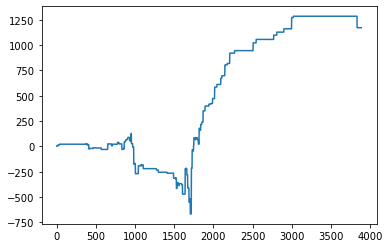

In [26]:
d = []
d2 = []
li = []
highlonggold = []
highlongsilver = []
keys = {}
profits =[]
betas = []
positive = 0
negative = 0
bilateral =True
owneda = False
ownedb = False
silverprofit = 0
goldprofit = 0
li=[]
plop = []
days = 0
k = []
key = 'OLS4diff2difference1AR60AR1'
for key in ['OLS2AR55AR1']:
    func = []
    positive = 0
    negative = 0
    bilateral =True
    owneda = False
    ownedb = False
    silverprofit = 0
    goldprofit = 0
    li=[]
    for val in models[key][9]:
        li.append(val)
    arr = np.array(li)
    std = np.std(arr)
    tom = std*(2)
    m = np.mean(arr)
    days =0 
    for time in range(0,len(models[key][5])):
        #print(models[key][3][time])
        #print(models[key][3][time])
        k.append(models[key][5][time])
        if owneda == False and (models[key][9][time] > 1*tom+m) and ownedb == False:
                owneda = True
                ratio = models[key][3][time] / models[key][2][time]
                print(str(time) + ' : ' + str(models[key][5][time]) + ' Silver' + str(models[key][2][time] * ratio))
                print(str(time) + ' : ' + str(models[key][5][time]) + ' Gold ' + str(models[key][3][time]))
                silver = models[key][2][time] * ratio
                gold =  models[key][3][time]
        if owneda:
            days+=1
            if models[key][9][time]<0.4*std+m and models[key][9][time]>-0.4*std+m:
                owneda = False
                highlonggold.append(silver-models[key][2][time]*ratio+models[key][3][time]-gold)
                highlongsilver.append(-1*(silver-models[key][2][time]*ratio+models[key][3][time]-gold))
                print(str(time) + ' : ' + str(models[key][5][time]) + ' Silver' + str(models[key][2][time]*ratio))
                print(str(time) + ' : ' + str(models[key][5][time]) + ' Gold ' + str(models[key][3][time]))
                silverprofit -= silver - models[key][2][time]*ratio
               # print(silverprofit+goldprofit)
                if bilateral:
                    goldprofit -= models[key][3][time] - gold
                if ((models[key][2][time]*ratio - silver+gold - models[key][3][time])>0):
                    positive += 1
                    d.append(days)
                    days = 0
                elif ((models[key][2][time]*ratio - silver+gold - models[key][3][time])<0):
                    negative += 1
                    d2.append(days)
                    days = 0
        if  models[key][9][time] < -1*tom+m and owneda == False and ownedb == False:
            ownedb=True
            ratio = models[key][3][time] / models[key][2][time]
            print(str(time) + ' : ' + str(models[key][5][time]) + ' Silver' + str(models[key][2][time]*ratio))
            print(str(time) + ' : ' + str(models[key][5][time]) + ' Gold ' + str(models[key][3][time]))
            silver =  models[key][2][time] * ratio
            if bilateral:
                gold = models[key][3][time]
        if ownedb: 
            days+=1
            if models[key][9][time]<0.4*std+m and models[key][9][time]>-0.4*std+m:
                ownedb = False
                highlonggold.append(-1*(silver-models[key][2][time]*ratio+models[key][3][time]-gold))
                highlongsilver.append(1*(silver-models[key][2][time]*ratio+models[key][3][time]-gold))
                print(str(time) + ' : ' + str(models[key][5][time]) + ' Silver' + str(models[key][2][time]*ratio))
                print(str(time) + ' : ' + str(models[key][5][time]) + ' Gold ' + str(models[key][3][time]))
                if bilateral:
                    goldprofit -= gold - models[key][3][time]
                #print(models[key][2][time]*ratio - silver+gold - models[key][3][time])
                silverprofit -=  models[key][2][time]*ratio - silver
                if ((models[key][2][time]*ratio - silver+gold - models[key][3][time])>0):
                    positive += 1
                    d.append(days)
                    days = 0
                elif ((models[key][2][time]*ratio - silver+gold - models[key][3][time])<0):
                    negative += 1
                    d2.append(days)
                    days = 0
        plop.append(silverprofit+goldprofit)            
    total = positive+negative
    if (silverprofit+goldprofit)>0 and total>30:
        print(key)
        #print('Percent Correct: ' + str((1.0*positive)/total))
        print('Total Trades: ' + str(positive+negative))
        print('Total Profit' + str(goldprofit+silverprofit))
        print('Silver: ' + str(silverprofit))
        print('Gold: ' + str(goldprofit))
        betas.append((1.0*positive)/total)
        print('Average Days Until Profit: ' + str(np.mean(d)))
        print('Average Days Until Loss: '+ str(np.mean(d2)))
        profits.append(silverprofit+goldprofit)
plt.plot(plop)

In [ ]:
print(np.std(SI_F)/np.mean(SI_F))
print(np.std(GC_F)/np.mean(GC_F))

In [ ]:
print(models['OLS3difference1'][1][1])
print(np.std(models['OLS3difference1'][5]))

ALPHA: OLS3diff2difference1AR1
BETA: OLS1diff365determinstictrend2difference1AR24GARCH1
BEST: OLS1determinstictrend82difference1AR60AR1

## Model Summary


In [ ]:
key = 'OLS2AR55AR1'
print(key)
plt.plot(models[key][9])
print('Standard Deviation: ')
print(np.mean(models[key][9]))
print("Relative Standard Deviations: ")
print(np.std(models[key][7]/np.mean(models[key][7])))
print(np.std(models[key][8]/np.mean(models[key][8])))
print('Parameters')
print(models[key][1])

In [ ]:
print(models['OLS4diff2difference1AR60AR1'][1][0]*10000000000)

In [ ]:
trades = 0


In [ ]:
def add_trade(s,e,type):
    vals = 0
    if type == 's':
        vals+=(s-e)/s
    else:
        vals+=(e-s)/s
    return vals

In [ ]:
trades = 0
trades+= add_trade(17.385,16.67,'s')
trades+= add_trade(15.195,15.21,'s')
trades+=add_trade(17.575,18.46,'s')
trades+=add_trade(18.49,19.665,'l')
trades+=add_trade(17.725,17.74,'s')
trades+=add_trade(18.33,18.09,'l')
trades+=add_trade(26.775,28.47,'l')
trades+=add_trade(25.51,26.54,'s')
trades+=add_trade(17.525,17.505,'l')
trades+=add_trade(26.845,26.91,'s')
trades+=add_trade(27.44,26.76,'s')

In [ ]:
print(trades)

In [ ]:
def gavin(a,b):
    profitsa = 0
    profitsb = 0
    profits = 0
    tradesaa = []
    val = 0
    while(val<len(a)):
        profitsa+=((a[val+1]-a[val])/a[val])
        tradesaa.append((a[val+1]-a[val])/a[val])
        print('Long: '+ str((a[val+1]-a[val])/a[val]))
        val+=2
    val = 0
    while(val<len(b)):
        profitsb+=(b[val]-b[val+1])/b[val]
        tradesaa.append((b[val]-b[val+1])/b[val])
        print('Short:' + str((b[val]-b[val+1])/b[val]))
        val+=2
    profits = profitsa+profitsb
    print(profitsa)
    print(profitsb)
    print(profits)
    print(max(tradesaa))
    print(min(tradesaa))
    print(np.mean(np.array(tradesaa)))

In [23]:
key = 'OLS2AR3'
profts = []
for key in ['OLS2AR3']:
    counts = []
    op = []
    boola = False
    xy = []
    count = 0
    boolb=False
    silver  = 0
    prof =0
    for val in range(0,len(models[key][5])):
        a= np.log(models[key][3][val])-(models[key][5][val]+ models[key][2][val]*models[key][1][1]+models[key][1][0])
        op.append(a)
    m = np.mean(op)
    std =np.std(op)
    for val in range(0,len(models[key][5])):
        a= np.log(models[key][3][val])-(models[key][5][val]+ models[key][2][val]*models[key][1][1]+models[key][1][0])
        op.append(a)
        if(a>m+std*2) and boola == False:
            #print('X Over:  ' + str(models[key][2][val]))
            #print('Y Over: ' + str(models[key][3][val]))
            copper = models[key][2][val]
            silver = models[key][3][val]
            boola = True
        elif((a<m-std*2)) and boolb == False:
            #print('X Under:  ' + str(models[key][2][val]))
            #print('Y Under: ' + str(models[key][3][val]))
            copper = models[key][2][val]
            silver = models[key][3][val]
            boolb=True
        if(boola):
            count+=1
            if(a <(m+std*0.4)):
                boola=False
                #print('X Trade:  ' + str(((models[key][2][val])-copper)/copper))
                #print('Y Trade: ' + str(((silver-models[key][3][val])/silver)))
                prof += ((models[key][2][val])-copper)/copper
                prof += ((silver-models[key][3][val]))/silver
                counts.append(count)
                count = 0
        if(boolb):
            count+=1
            if(a>m-std*0.4):
                boolb=False
                #print('X Trade:  ' + str(((models[key][2][val])-copper)/copper))
                #print('Y Trade: ' + str((silver-models[key][3][val])/silver))
                prof -= ((models[key][2][val])-copper)/copper
                prof -= ((silver-models[key][3][val]))/silver
                counts.append(count)
                count = 0
    profits.append(prof)
    print(prof)
    print(key + "^^")
print(max(profits))
plt.plot(profits)

KeyError: 'OLS2AR3'

In [27]:
print(models['OLS2AR3'][1])
print(np.mean(models['OLS2AR3'][9]))
print(models['OLS2AR3'][10])
print(np.std(models['OLS2AR3'][9]))
print(models['OLS2AR3'][11])

[6.85363792560481 0.12274166926561736
 list([0.9663724912211216, -0.02101755899652041, 0.05191635065912223])]
0.0005603271632047667
0.0005603271632047667
0.0192890175744759
0.0192890175744759


In [ ]:
profits = []
counts = []
for key in ['OLS2AR53AR1']:
    print(np.mean(models[key][5]))
    si = []
    for val in models[key][3]:
        si.append(np.log(models[key][3]))
    print(np.mean(si))
    print(np.mean(models[key][4]))
    op = []
    boola = False
    xy = []
    count = 0
    boolb=False
    silver  = 0
    prof =0
    for val in range(0,len(models[key][5])):
        a= np.log(models[key][3][val])-(models[key][5][val]+ models[key][2][val]*models[key][1][1]+models[key][1][0])
        op.append(a)
    m = np.mean(op)
    std =np.std(op)
    for val in range(0,len(models[key][5])):
        a= np.log(models[key][3][val])-(models[key][5][val]+ models[key][2][val]*models[key][1][1]+models[key][1][0])
        op.append(a)
        if(a>m+std*2) and boola == False:
            #print('Copper Over:  ' + str(models[key][2][val]))
            #print('Silver Over: ' + str(models[key][3][val]))
            copper = models[key][2][val]
            silver = models[key][3][val]
            boola = True
        elif((a<-(m+std*2))) and boolb == False:
            #print('Copper Under:  ' + str(models[key][2][val]))
            #print('Silver Under: ' + str(models[key][3][val]))
            copper = models[key][2][val]
            silver = models[key][3][val]
            boolb=True
        if(boola):
            count+=1
            if(a <(m+std*0.4)):
                boola=False
                counts.append(count)
                print(count)
                print((((models[key][2][val])-copper)/copper
                +((silver-models[key][3][val])/silver)))
                
                count = 0
                #print('Copper Trade:  ' + str(models[key][2][val]))
                #print('Silver Trade: ' + str(models[key][3][val]))
                prof += ((models[key][2][val])-copper)/copper
                prof += ((silver-models[key][3][val]))/silver
        elif(boolb):
            count+=1
            if(a>-(m+std*0.4)):
                boolb=False
                counts.append(count)
                print(count)
                print(-(((models[key][2][val])-copper)/copper
                +((silver-models[key][3][val])/silver)))
                count = 0
                #print('Copper Trade:  ' + str(models[key][2][val]))
                #print('Silver Trade: ' + str(models[key][3][val]))
                prof -= ((models[key][2][val])-copper)/copper
                prof -= ((silver-models[key][3][val]))/silver
    if(prof>0):
        print(key)
        print(prof)
        profits.append(prof)
        std = np.std(op)
        m = np.mean(op)
        print()
print(max(profits))
print(counts)
plt.plot(op)

In [ ]:
def model(y,x,val,param1,param2):
    eps = []
    mod=[]
    if val ==3:
        for num in range(0,len(y)):
            eps.append(y[num]-(np.log(x[num])*param2+param1))
            mod.append((np.log(x[num])*param2+param1))
    elif val ==1:
        for num in range(0,len(y)):
            eps.append(y[num]-((x[num])*param2+param1))
            mod.append(((x[num])*param2+param1))
    elif val ==4:
        for num in range(0,len(y)):
            eps.append(np.log(y[num])-(np.log(x[num])*param2+param1))
            mod.append(((x[num])*param2+param1))
    else:
        for num in range(0,len(y)):
            eps.append(np.log(y[num])-(x[num])*param2+param1)
            mod.append(((x[num])*param2+param1))
    return eps,mod

In [ ]:
print(np.mean(models['OLS2AR53AR1'][9]))
print(np.std(models['OLS2AR53AR1'][9]))
print(models['OLS2AR53AR1'][1])

In [ ]:
faang = []
for time in range(0,len(models[key][7])):
    faang.append(models[key][1][0]*models[key][7][time]+models[key][1][1])
print(np.mean(faang))

1.5460370354333906e-14


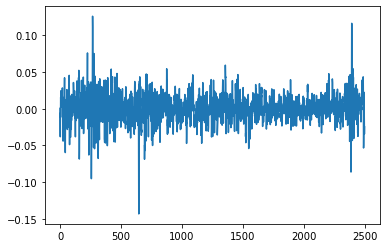

In [28]:
a = adfuller(models['OLS2AR3'][9])
print(a[1])
plt.plot(models['OLS2AR3'][9])

In [ ]:
b = np.std(GC_F)/np.mean(GC_F)
a = np.std(SI_F)/np.mean(SI_F)
print(a/(a+b))
print(b/(a+b))